In [1]:
# Import necessary libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation, Input, Add
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
# Set the image dimensions and channels
h, w = 50, 50  # Height and Width of images
n_channels = 1  # Since images are grayscale, 1 channel
n_classes = 4  # Number of output classes for classification
l2_lambda = 0.0001  # Regularization parameter for L2 regularization

# Load your preprocessed image data
X = np.load('X.npy')  # The X.npy contains the flattened grayscale image data
y = np.load('y.npy', allow_pickle=True)  # y.npy contains the labels for the images
X1 = X.reshape(-1, h, w, n_channels)  # Reshaping to match the input required for CNNs (height, width, channels)

# Data Augmentation for improving model generalization
datagen = ImageDataGenerator(
    rotation_range=5,  # Random rotations
    width_shift_range=0.1,  # Horizontal shifts
    height_shift_range=0.1,  # Vertical shifts
    horizontal_flip=True,  # Flip images horizontally
    vertical_flip=True,  # Flip images vertically
    fill_mode='nearest'  # Strategy to fill in pixels after augmentation
)

datagen.fit(X1)  # Fit the generator to the data

# Label encoding (from string labels to numeric values) for multi-class classification
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)  # Transform string labels to integer
y_ohe = to_categorical(y_encoded, num_classes=n_classes)  # One-hot encode the integer labels for model training


In [3]:
# Define AlexNet1 Model
def create_alexnet1():
    model = Sequential(name='alexnet1')
    num_filt_layers = [32, 64, 128]  # Number of filters in each Conv layer
    for num_filters in num_filt_layers:
        model.add(Conv2D(filters=num_filters, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(h, w, n_channels)))
        model.add(MaxPooling2D(pool_size=(2, 2)))  # Max pooling layer to reduce spatial dimensions
    model.add(Flatten())  # Flatten the output from conv layers to feed into fully connected layers
    model.add(Dense(128, activation='relu'))  # Fully connected layer with 128 neurons
    model.add(Dense(128, activation='relu'))  # Second fully connected layer
    model.add(Dense(n_classes, activation='softmax'))  # Output layer with softmax activation
    return model


In [4]:
# Define AlexNet2 Model
def create_alexnet2():
    model = Sequential(name='alexnet2')
    num_filt_layers = [64, 128, 256]  # Higher number of filters in this version
    for num_filters in num_filt_layers:
        model.add(Conv2D(filters=num_filters, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(h, w, n_channels)))
        model.add(MaxPooling2D(pool_size=(3, 3)))  # Larger pooling window for more aggressive downsampling
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))  # Larger fully connected layer with 256 neurons
    model.add(Dense(256, activation='relu'))
    model.add(Dense(n_classes, activation='softmax'))  # Output layer for multi-class classification
    return model


In [5]:
# Define ResNet1 Model with residual connections
def create_resnet1():
    input_holder = Input(shape=(h, w, n_channels))  # Input layer
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(input_holder)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(x)
    x_split = MaxPooling2D((2, 2))(x)  # This layer will be added back via residual connections
    x = Conv2D(64, (1, 1), padding='same', activation='linear')(x_split)
    x = Conv2D(64, (3, 3), padding='same', activation='linear')(x)
    x = Conv2D(32, (1, 1), padding='same', activation='relu')(x)
    x = Add()([x, x_split])  # Adding residual connection
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x)
    x = Dropout(0.25)(x)  # Dropout for regularization
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(n_classes, activation='softmax')(x)
    return Model(inputs=input_holder, outputs=x, name='resnet1')


In [6]:
# Define ResNet2 Model with deeper architecture
def create_resnet2():
    input_holder = Input(shape=(h, w, n_channels))
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(input_holder)
    x = MaxPooling2D((3, 3))(x)
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x_split = MaxPooling2D((3, 3))(x)
    x = Conv2D(64, (1, 1), padding='same', activation='linear')(x_split)
    x = Conv2D(64, (3, 3), padding='same', activation='linear')(x)
    x = Conv2D(64, (1, 1), padding='same', activation='relu')(x)
    x = Add()([x, x_split])  # Adding the residual connection
    x = Activation('relu')(x)
    x = MaxPooling2D((3, 3))(x)
    x = Flatten()(x)
    x = Dropout(0.25)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(n_classes, activation='softmax')(x)
    return Model(inputs=input_holder, outputs=x, name='resnet2')


In [7]:
# Define MLP model
def create_mlp():
    model = Sequential(name='mlp')
    model.add(Flatten(input_shape=(h, w, n_channels)))  # Flatten the input (50x50x1) into a vector
    model.add(Dense(30, activation='relu'))  # Dense layer with 30 neurons
    model.add(Dense(15, activation='relu'))  # Dense layer with 15 neurons
    model.add(Dense(n_classes, activation='softmax'))  # Output layer with softmax activation
    return model



In [8]:
def train_and_evaluate(model, X, y, n_splits=10, batch_size=32, epochs=20):
    skf = StratifiedKFold(n_splits=n_splits)  # Stratified K-fold cross-validation
    precision_all = np.empty((0, n_classes), float)  # Placeholder for precision scores
    history_all = []  # To store history for each fold

    # Iterate over each fold
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        # Augment training data
        datagen.fit(X_train)
        
        # Compile the model
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        
        # Train the model and save the history
        history = model.fit(datagen.flow(X_train, to_categorical(y_train, n_classes), batch_size=batch_size),
                            validation_data=(X_test, to_categorical(y_test, n_classes)),
                            steps_per_epoch=len(X_train) // batch_size,
                            epochs=epochs,
                            callbacks=[
                                EarlyStopping(monitor='val_loss', patience=5),  # Stop early if no improvement
                                ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3)  # Reduce learning rate on plateau
                            ])
        
        # Save the training history for this fold
        history_all.append(history)

        # Predict the test set
        y_pred = np.argmax(model.predict(X_test), axis=1)
        
        # Calculate precision scores
        precision_scores = precision_score(y_test, y_pred, average=None)
        precision_all = np.append(precision_all, [precision_scores], axis=0)
        print(f"Precision: {precision_scores * 100}")  # Print precision for each class
    
    # Calculate mean precision across all folds
    precision_mean = np.mean(precision_all, axis=0)
    print("Mean precision scores over 10 folds: ", precision_mean)
    
    return precision_all, precision_mean, history_all  # Return history_all too


In [9]:
# Instantiate models
alexnet1 = create_alexnet1()
alexnet2 = create_alexnet2()
resnet1 = create_resnet1()
resnet2 = create_resnet2()
mlp = create_mlp()

# Train and evaluate each model
models = [alexnet1, alexnet2, resnet1, resnet2, mlp]
model_names = ["AlexNet1", "AlexNet2", "ResNet1", "ResNet2", "MLP"]
precision_results = {}

# Train and evaluate each model, store the precision results and history
for model, name in zip(models, model_names):
    print(f"Training {name} model")
    precision_all, precision_mean, history_all = train_and_evaluate(model, X1, y_encoded)
    precision_results[name] = (precision_all, precision_mean, history_all)


Training AlexNet1 model
Epoch 1/20


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


 5/19 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.2320 - loss: 1.3905

/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.3401 - loss: 1.3264 - val_accuracy: 0.4429 - val_loss: 1.3553 - learning_rate: 0.0010
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3438 - loss: 0.5655 - val_accuracy: 0.4429 - val_loss: 1.2947 - learning_rate: 0.0010
Epoch 3/20
 3/19 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.4670 - loss: 1.0544

2024-10-21 22:29:06.511083: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/opt/anaconda3/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.5333 - loss: 1.0292 - val_accuracy: 0.4000 - val_loss: 1.5705 - learning_rate: 0.0010
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4062 - loss: 0.7119 - val_accuracy: 0.4286 - val_loss: 1.4776 - learning_rate: 0.0010
Epoch 5/20
 3/19 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5104 - loss: 1.1236

2024-10-21 22:29:07.163306: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.5855 - loss: 0.9980 - val_accuracy: 0.5143 - val_loss: 1.4856 - learning_rate: 0.0010
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6875 - loss: 0.3868 - val_accuracy: 0.5143 - val_loss: 1.4791 - learning_rate: 1.0000e-04
Epoch 7/20
 5/19 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6699 - loss: 0.8097

2024-10-21 22:29:07.783379: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.6812 - loss: 0.8249 - val_accuracy: 0.5857 - val_loss: 1.3692 - learning_rate: 1.0000e-04
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Precision: [50.         50.         82.35294118 51.85185185]
Epoch 1/20
 5/19 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7273 - loss: 0.9938

/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.6725 - loss: 0.9995 - val_accuracy: 0.7286 - val_loss: 0.9423 - learning_rate: 0.0010
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3750 - loss: 0.5965 - val_accuracy: 0.7286 - val_loss: 0.9383 - learning_rate: 0.0010
Epoch 3/20
 3/19 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.6684 - loss: 0.9342

2024-10-21 22:29:09.550101: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/opt/anaconda3/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.6978 - loss: 0.8542 - val_accuracy: 0.7286 - val_loss: 0.9122 - learning_rate: 0.0010
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6562 - loss: 0.3845 - val_accuracy: 0.7286 - val_loss: 0.9349 - learning_rate: 0.0010
Epoch 5/20
 3/19 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6545 - loss: 0.6408

2024-10-21 22:29:10.204820: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.6654 - loss: 0.7287 - val_accuracy: 0.7143 - val_loss: 1.1146 - learning_rate: 0.0010
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6562 - loss: 0.4422 - val_accuracy: 0.7429 - val_loss: 1.0854 - learning_rate: 0.0010
Epoch 7/20
 5/19 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6245 - loss: 0.8190

2024-10-21 22:29:10.819362: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.6823 - loss: 0.7529 - val_accuracy: 0.7429 - val_loss: 0.9287 - learning_rate: 1.0000e-04
Epoch 8/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6250 - loss: 0.4351 - val_accuracy: 0.7429 - val_loss: 0.9232 - learning_rate: 1.0000e-04
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Precision: [90.         50.         94.73684211 68.        ]
Epoch 1/20


2024-10-21 22:29:11.424093: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


 6/19 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7339 - loss: 0.7140

/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.6994 - loss: 0.7686 - val_accuracy: 0.6857 - val_loss: 0.7517 - learning_rate: 0.0010
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6875 - loss: 0.3611 - val_accuracy: 0.6571 - val_loss: 0.7940 - learning_rate: 0.0010
Epoch 3/20
 4/19 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6836 - loss: 0.7887

2024-10-21 22:29:12.546319: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/opt/anaconda3/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.6755 - loss: 0.7816 - val_accuracy: 0.7429 - val_loss: 0.7830 - learning_rate: 0.0010
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6562 - loss: 0.3983 - val_accuracy: 0.7143 - val_loss: 0.8360 - learning_rate: 0.0010
Epoch 5/20
 5/19 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.7641 - loss: 0.5711

2024-10-21 22:29:13.126884: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.7418 - loss: 0.6554 - val_accuracy: 0.7000 - val_loss: 0.7812 - learning_rate: 1.0000e-04
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6818 - loss: 0.3176 - val_accuracy: 0.7000 - val_loss: 0.7816 - learning_rate: 1.0000e-04
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/stepWARNING:tensorflow:6 out of the last 9 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x14f46f600> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorfl

2024-10-21 22:29:13.732430: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


 5/19 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6780 - loss: 0.6841

/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.6686 - loss: 0.7494 - val_accuracy: 0.6714 - val_loss: 0.6222 - learning_rate: 0.0010
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7188 - loss: 0.3747 - val_accuracy: 0.7000 - val_loss: 0.6094 - learning_rate: 0.0010
Epoch 3/20
 3/19 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6944 - loss: 0.6990

2024-10-21 22:29:14.868337: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/opt/anaconda3/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.7131 - loss: 0.7076 - val_accuracy: 0.7571 - val_loss: 0.5568 - learning_rate: 0.0010
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6562 - loss: 0.3714 - val_accuracy: 0.7429 - val_loss: 0.5606 - learning_rate: 0.0010
Epoch 5/20
 5/19 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.6510 - loss: 0.8142

2024-10-21 22:29:15.454565: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.7042 - loss: 0.7004 - val_accuracy: 0.6571 - val_loss: 0.6847 - learning_rate: 0.0010
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7812 - loss: 0.3740 - val_accuracy: 0.7000 - val_loss: 0.6490 - learning_rate: 0.0010
Epoch 7/20
 5/19 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.6369 - loss: 0.8017

2024-10-21 22:29:16.055613: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.6807 - loss: 0.7608 - val_accuracy: 0.7571 - val_loss: 0.5543 - learning_rate: 1.0000e-04
Epoch 8/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7188 - loss: 0.2982 - val_accuracy: 0.7571 - val_loss: 0.5486 - learning_rate: 1.0000e-04
Epoch 9/20
 3/19 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7535 - loss: 0.6171

2024-10-21 22:29:16.664979: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.7631 - loss: 0.5937 - val_accuracy: 0.7571 - val_loss: 0.5322 - learning_rate: 1.0000e-04
Epoch 10/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7500 - loss: 0.3559 - val_accuracy: 0.7571 - val_loss: 0.5282 - learning_rate: 1.0000e-04
Epoch 11/20
 3/19 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.7847 - loss: 0.5574

2024-10-21 22:29:17.369322: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.7657 - loss: 0.6053 - val_accuracy: 0.7571 - val_loss: 0.5193 - learning_rate: 1.0000e-04
Epoch 12/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8125 - loss: 0.2658 - val_accuracy: 0.7571 - val_loss: 0.5289 - learning_rate: 1.0000e-04
Epoch 13/20
 2/19 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - accuracy: 0.7031 - loss: 0.7671

2024-10-21 22:29:18.150804: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.7390 - loss: 0.6167 - val_accuracy: 0.7429 - val_loss: 0.5588 - learning_rate: 1.0000e-04
Epoch 14/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6562 - loss: 0.3685 - val_accuracy: 0.7571 - val_loss: 0.5518 - learning_rate: 1.0000e-04
Epoch 15/20
 3/19 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.7552 - loss: 0.5489

2024-10-21 22:29:19.025084: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.7501 - loss: 0.5942 - val_accuracy: 0.7571 - val_loss: 0.5405 - learning_rate: 1.0000e-05
Epoch 16/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6250 - loss: 0.3795 - val_accuracy: 0.7571 - val_loss: 0.5396 - learning_rate: 1.0000e-05
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Precision: [100.          57.89473684 100.          67.85714286]


2024-10-21 22:29:19.707075: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


Epoch 1/20
 5/19 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7235 - loss: 0.8224 

/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.7296 - loss: 0.7309 - val_accuracy: 0.6143 - val_loss: 0.6519 - learning_rate: 0.0010
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8125 - loss: 0.3051 - val_accuracy: 0.6714 - val_loss: 0.6367 - learning_rate: 0.0010
Epoch 3/20
 3/19 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.6962 - loss: 0.6187

2024-10-21 22:29:21.185318: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/opt/anaconda3/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.7312 - loss: 0.6256 - val_accuracy: 0.6714 - val_loss: 0.7061 - learning_rate: 0.0010
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6875 - loss: 0.4552 - val_accuracy: 0.6714 - val_loss: 0.7253 - learning_rate: 0.0010
Epoch 5/20
 4/19 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6989 - loss: 0.6729

2024-10-21 22:29:21.851039: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.7273 - loss: 0.6336 - val_accuracy: 0.6000 - val_loss: 0.8249 - learning_rate: 0.0010
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7188 - loss: 0.3276 - val_accuracy: 0.6000 - val_loss: 0.8298 - learning_rate: 1.0000e-04
Epoch 7/20
 3/19 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.6840 - loss: 0.7754

2024-10-21 22:29:22.472335: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.7138 - loss: 0.6737 - val_accuracy: 0.5714 - val_loss: 0.6517 - learning_rate: 1.0000e-04
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step 
Precision: [57.14285714 35.         88.23529412 53.84615385]
Epoch 1/20
 5/19 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7994 - loss: 0.5507

/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.7482 - loss: 0.6128 - val_accuracy: 0.8000 - val_loss: 0.9307 - learning_rate: 0.0010
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8125 - loss: 0.2839 - val_accuracy: 0.7714 - val_loss: 0.9452 - learning_rate: 0.0010
Epoch 3/20
 4/19 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8322 - loss: 0.5517

2024-10-21 22:29:24.453500: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/opt/anaconda3/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.7845 - loss: 0.6057 - val_accuracy: 0.7857 - val_loss: 1.0238 - learning_rate: 0.0010
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7812 - loss: 0.2977 - val_accuracy: 0.8000 - val_loss: 0.9808 - learning_rate: 0.0010
Epoch 5/20
 5/19 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.7442 - loss: 0.5865

2024-10-21 22:29:25.058807: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.7461 - loss: 0.5829 - val_accuracy: 0.7857 - val_loss: 0.9231 - learning_rate: 1.0000e-04
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6875 - loss: 0.3324 - val_accuracy: 0.8000 - val_loss: 0.9208 - learning_rate: 1.0000e-04
Epoch 7/20
 5/19 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7044 - loss: 0.6589

2024-10-21 22:29:25.656091: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.7172 - loss: 0.6507 - val_accuracy: 0.8286 - val_loss: 0.8876 - learning_rate: 1.0000e-04
Epoch 8/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7500 - loss: 0.2752 - val_accuracy: 0.8286 - val_loss: 0.8891 - learning_rate: 1.0000e-04
Epoch 9/20
 5/19 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8050 - loss: 0.4733

2024-10-21 22:29:26.242453: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.7796 - loss: 0.5270 - val_accuracy: 0.8286 - val_loss: 0.9046 - learning_rate: 1.0000e-04
Epoch 10/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7727 - loss: 0.2440 - val_accuracy: 0.8286 - val_loss: 0.9037 - learning_rate: 1.0000e-04
Epoch 11/20
 3/19 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7309 - loss: 0.5603

2024-10-21 22:29:26.901368: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.7334 - loss: 0.5849 - val_accuracy: 0.8143 - val_loss: 0.9065 - learning_rate: 1.0000e-05
Epoch 12/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7188 - loss: 0.3610 - val_accuracy: 0.8286 - val_loss: 0.9068 - learning_rate: 1.0000e-05
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Precision: [90.90909091 82.35294118 88.88888889 75.        ]
Epoch 1/20


2024-10-21 22:29:27.565061: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


 6/19 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7910 - loss: 0.5842

/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.7470 - loss: 0.6436 - val_accuracy: 0.8000 - val_loss: 0.4911 - learning_rate: 0.0010
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8438 - loss: 0.2312 - val_accuracy: 0.8143 - val_loss: 0.4861 - learning_rate: 0.0010
Epoch 3/20
 5/19 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7334 - loss: 0.5949

/opt/anaconda3/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2024-10-21 22:29:28.726637: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.7389 - loss: 0.6240 - val_accuracy: 0.8000 - val_loss: 0.4575 - learning_rate: 0.0010
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7188 - loss: 0.3002 - val_accuracy: 0.8000 - val_loss: 0.4656 - learning_rate: 0.0010
Epoch 5/20
 3/19 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6407 - loss: 0.6822

2024-10-21 22:29:29.353789: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.7179 - loss: 0.6330 - val_accuracy: 0.8286 - val_loss: 0.4709 - learning_rate: 0.0010
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8438 - loss: 0.2334 - val_accuracy: 0.8143 - val_loss: 0.5029 - learning_rate: 0.0010
Epoch 7/20
 3/19 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7257 - loss: 0.6602

2024-10-21 22:29:30.112658: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.7573 - loss: 0.5941 - val_accuracy: 0.8429 - val_loss: 0.4369 - learning_rate: 1.0000e-04
Epoch 8/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7500 - loss: 0.3441 - val_accuracy: 0.8429 - val_loss: 0.4372 - learning_rate: 1.0000e-04
Epoch 9/20
 3/19 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.6545 - loss: 0.7196

2024-10-21 22:29:31.006064: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.7371 - loss: 0.5823 - val_accuracy: 0.8429 - val_loss: 0.4405 - learning_rate: 1.0000e-04
Epoch 10/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6875 - loss: 0.3670 - val_accuracy: 0.8429 - val_loss: 0.4423 - learning_rate: 1.0000e-04
Epoch 11/20
 3/19 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7934 - loss: 0.4358

2024-10-21 22:29:31.678851: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.7871 - loss: 0.4985 - val_accuracy: 0.8429 - val_loss: 0.4401 - learning_rate: 1.0000e-05
Epoch 12/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8125 - loss: 0.2602 - val_accuracy: 0.8429 - val_loss: 0.4400 - learning_rate: 1.0000e-05
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Precision: [100.          62.96296296 100.          94.73684211]
Epoch 1/20


2024-10-21 22:29:32.406350: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


 5/19 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.7610 - loss: 0.5690

/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.7706 - loss: 0.5744 - val_accuracy: 0.7714 - val_loss: 0.6562 - learning_rate: 0.0010
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6818 - loss: 0.3266 - val_accuracy: 0.7143 - val_loss: 0.7142 - learning_rate: 0.0010
Epoch 3/20
 5/19 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7439 - loss: 0.6208

/opt/anaconda3/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2024-10-21 22:29:33.654389: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.7478 - loss: 0.6061 - val_accuracy: 0.7286 - val_loss: 0.7724 - learning_rate: 0.0010
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8438 - loss: 0.2154 - val_accuracy: 0.7286 - val_loss: 0.7778 - learning_rate: 0.0010
Epoch 5/20
 2/19 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 0.7113 - loss: 0.6097

2024-10-21 22:29:34.297283: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.7586 - loss: 0.5585 - val_accuracy: 0.7857 - val_loss: 0.6910 - learning_rate: 1.0000e-04
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8438 - loss: 0.2134 - val_accuracy: 0.7857 - val_loss: 0.6892 - learning_rate: 1.0000e-04
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Precision: [88.88888889 60.         90.         80.95238095]
Epoch 1/20


2024-10-21 22:29:35.088595: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


 5/19 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7546 - loss: 0.6071

/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.7487 - loss: 0.6177 - val_accuracy: 0.7286 - val_loss: 0.6219 - learning_rate: 0.0010
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7188 - loss: 0.2837 - val_accuracy: 0.8286 - val_loss: 0.5942 - learning_rate: 0.0010
Epoch 3/20
 5/19 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.7708 - loss: 0.5716

2024-10-21 22:29:36.261745: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/opt/anaconda3/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.7497 - loss: 0.5718 - val_accuracy: 0.8714 - val_loss: 0.4781 - learning_rate: 0.0010
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8125 - loss: 0.2747 - val_accuracy: 0.8429 - val_loss: 0.4795 - learning_rate: 0.0010
Epoch 5/20
 4/19 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7363 - loss: 0.6181

2024-10-21 22:29:36.864999: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.7772 - loss: 0.5421 - val_accuracy: 0.8286 - val_loss: 0.5855 - learning_rate: 0.0010
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6250 - loss: 0.3718 - val_accuracy: 0.8429 - val_loss: 0.6001 - learning_rate: 0.0010
Epoch 7/20
 3/19 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6597 - loss: 0.5445

2024-10-21 22:29:37.444482: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.7400 - loss: 0.5344 - val_accuracy: 0.8429 - val_loss: 0.4995 - learning_rate: 1.0000e-04
Epoch 8/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8750 - loss: 0.1654 - val_accuracy: 0.8286 - val_loss: 0.4968 - learning_rate: 1.0000e-04
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Precision: [85.71428571 66.66666667 94.44444444 88.23529412]
Epoch 1/20


2024-10-21 22:29:38.109487: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


 6/19 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7236 - loss: 0.6528

/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.7384 - loss: 0.6291 - val_accuracy: 0.8429 - val_loss: 0.4276 - learning_rate: 0.0010
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7500 - loss: 0.2574 - val_accuracy: 0.8429 - val_loss: 0.4367 - learning_rate: 0.0010
Epoch 3/20
 5/19 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8121 - loss: 0.4917

2024-10-21 22:29:39.272499: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/opt/anaconda3/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.7878 - loss: 0.5279 - val_accuracy: 0.7571 - val_loss: 0.4614 - learning_rate: 0.0010
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7812 - loss: 0.2873 - val_accuracy: 0.7714 - val_loss: 0.4568 - learning_rate: 0.0010
Epoch 5/20
 5/19 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.7290 - loss: 0.6903

2024-10-21 22:29:39.849855: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.7524 - loss: 0.6142 - val_accuracy: 0.8143 - val_loss: 0.4294 - learning_rate: 1.0000e-04
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7188 - loss: 0.3142 - val_accuracy: 0.8143 - val_loss: 0.4265 - learning_rate: 1.0000e-04
Epoch 7/20
 5/19 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7918 - loss: 0.4959

2024-10-21 22:29:40.455814: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.7730 - loss: 0.5031 - val_accuracy: 0.8286 - val_loss: 0.3869 - learning_rate: 1.0000e-04
Epoch 8/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8750 - loss: 0.1827 - val_accuracy: 0.8286 - val_loss: 0.3852 - learning_rate: 1.0000e-04
Epoch 9/20
 5/19 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.7947 - loss: 0.5261

2024-10-21 22:29:41.035002: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.7942 - loss: 0.5008 - val_accuracy: 0.8286 - val_loss: 0.3801 - learning_rate: 1.0000e-04
Epoch 10/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7812 - loss: 0.2400 - val_accuracy: 0.8286 - val_loss: 0.3801 - learning_rate: 1.0000e-04
Epoch 11/20
 5/19 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7916 - loss: 0.5681

2024-10-21 22:29:41.620324: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.8118 - loss: 0.4841 - val_accuracy: 0.8286 - val_loss: 0.3811 - learning_rate: 1.0000e-04
Epoch 12/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5909 - loss: 0.4206 - val_accuracy: 0.8286 - val_loss: 0.3790 - learning_rate: 1.0000e-04
Epoch 13/20
 5/19 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7341 - loss: 0.5632

2024-10-21 22:29:42.206815: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.7778 - loss: 0.4989 - val_accuracy: 0.8143 - val_loss: 0.3701 - learning_rate: 1.0000e-04
Epoch 14/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8125 - loss: 0.1931 - val_accuracy: 0.8143 - val_loss: 0.3700 - learning_rate: 1.0000e-04
Epoch 15/20
 4/19 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8372 - loss: 0.3838

2024-10-21 22:29:42.825517: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.8295 - loss: 0.4280 - val_accuracy: 0.8143 - val_loss: 0.3687 - learning_rate: 1.0000e-04
Epoch 16/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8125 - loss: 0.2594 - val_accuracy: 0.8143 - val_loss: 0.3691 - learning_rate: 1.0000e-04
Epoch 17/20
 3/19 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8073 - loss: 0.4010

2024-10-21 22:29:43.404656: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.8084 - loss: 0.4586 - val_accuracy: 0.8143 - val_loss: 0.3673 - learning_rate: 1.0000e-04
Epoch 18/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7500 - loss: 0.3331 - val_accuracy: 0.8143 - val_loss: 0.3655 - learning_rate: 1.0000e-04
Epoch 19/20
 5/19 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8315 - loss: 0.3860

2024-10-21 22:29:44.007673: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.8113 - loss: 0.4094 - val_accuracy: 0.8143 - val_loss: 0.3661 - learning_rate: 1.0000e-04
Epoch 20/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7188 - loss: 0.3305 - val_accuracy: 0.8143 - val_loss: 0.3704 - learning_rate: 1.0000e-04
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Precision: [100.          60.86956522  94.44444444  85.71428571]
Mean precision scores over 10 folds:  [0.84836941 0.57812783 0.91037558 0.74119395]
Training AlexNet2 model


2024-10-21 22:29:44.590893: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


Epoch 1/20
 3/19 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.1856 - loss: 1.3806  

/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.2996 - loss: 1.3130 - val_accuracy: 0.4143 - val_loss: 1.2004 - learning_rate: 0.0010
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3750 - loss: 0.5929 - val_accuracy: 0.4000 - val_loss: 1.2595 - learning_rate: 0.0010
Epoch 3/20
 2/19 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.5469 - loss: 0.9643

2024-10-21 22:29:46.225445: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/opt/anaconda3/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.4976 - loss: 1.0936 - val_accuracy: 0.4571 - val_loss: 1.2879 - learning_rate: 0.0010
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5312 - loss: 0.4915 - val_accuracy: 0.4714 - val_loss: 1.3078 - learning_rate: 0.0010
Epoch 5/20
 4/19 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5081 - loss: 1.0025

2024-10-21 22:29:47.022806: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.5155 - loss: 1.0156 - val_accuracy: 0.4857 - val_loss: 1.3495 - learning_rate: 1.0000e-04
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2812 - loss: 0.6231 - val_accuracy: 0.4714 - val_loss: 1.3455 - learning_rate: 1.0000e-04
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Precision: [39.13043478 41.66666667 63.63636364  0.        ]
Epoch 1/20


2024-10-21 22:29:47.671803: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


 5/19 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.4468 - loss: 1.1441

/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.4405 - loss: 1.1433 - val_accuracy: 0.4857 - val_loss: 1.1748 - learning_rate: 0.0010
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3438 - loss: 0.6646 - val_accuracy: 0.4857 - val_loss: 1.1427 - learning_rate: 0.0010
Epoch 3/20
 3/19 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.4080 - loss: 1.1356

2024-10-21 22:29:48.948038: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/opt/anaconda3/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.4296 - loss: 1.1390 - val_accuracy: 0.4571 - val_loss: 1.1129 - learning_rate: 0.0010
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5312 - loss: 0.4883 - val_accuracy: 0.5143 - val_loss: 1.1016 - learning_rate: 0.0010
Epoch 5/20
 1/19 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 0.5455 - loss: 1.1217

2024-10-21 22:29:49.794360: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.4883 - loss: 1.1101 - val_accuracy: 0.5857 - val_loss: 1.0160 - learning_rate: 0.0010
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5312 - loss: 0.5865 - val_accuracy: 0.6000 - val_loss: 1.0190 - learning_rate: 0.0010
Epoch 7/20
 3/19 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6337 - loss: 0.9781

2024-10-21 22:29:50.572271: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.5824 - loss: 1.0198 - val_accuracy: 0.6143 - val_loss: 0.9096 - learning_rate: 0.0010
Epoch 8/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5938 - loss: 0.5406 - val_accuracy: 0.6143 - val_loss: 0.9171 - learning_rate: 0.0010
Epoch 9/20
 3/19 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5556 - loss: 1.0261

2024-10-21 22:29:51.255675: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.5666 - loss: 1.0181 - val_accuracy: 0.6857 - val_loss: 0.9550 - learning_rate: 0.0010
Epoch 10/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5312 - loss: 0.4804 - val_accuracy: 0.7286 - val_loss: 0.9582 - learning_rate: 0.0010
Epoch 11/20
 3/19 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.6597 - loss: 0.8557

2024-10-21 22:29:51.956299: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.6492 - loss: 0.8856 - val_accuracy: 0.7429 - val_loss: 0.9266 - learning_rate: 1.0000e-04
Epoch 12/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6364 - loss: 0.5322 - val_accuracy: 0.7143 - val_loss: 0.9227 - learning_rate: 1.0000e-04
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Precision: [66.66666667 57.14285714 81.81818182 73.68421053]
Epoch 1/20


2024-10-21 22:29:52.694784: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


 5/19 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6890 - loss: 0.8792

/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.6252 - loss: 0.9532 - val_accuracy: 0.6714 - val_loss: 0.9246 - learning_rate: 0.0010
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5000 - loss: 0.5143 - val_accuracy: 0.6429 - val_loss: 1.0275 - learning_rate: 0.0010
Epoch 3/20
 3/19 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6476 - loss: 0.9362

2024-10-21 22:29:54.021311: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/opt/anaconda3/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.6149 - loss: 0.9274 - val_accuracy: 0.5286 - val_loss: 1.1699 - learning_rate: 0.0010
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6250 - loss: 0.4765 - val_accuracy: 0.5286 - val_loss: 1.1150 - learning_rate: 0.0010
Epoch 5/20
 4/19 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6866 - loss: 0.8469

2024-10-21 22:29:54.670729: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.6806 - loss: 0.8510 - val_accuracy: 0.6857 - val_loss: 0.8618 - learning_rate: 1.0000e-04
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7188 - loss: 0.4083 - val_accuracy: 0.6857 - val_loss: 0.8585 - learning_rate: 1.0000e-04
Epoch 7/20
 3/19 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5451 - loss: 1.0327

2024-10-21 22:29:55.317820: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.6335 - loss: 0.8953 - val_accuracy: 0.6714 - val_loss: 0.8712 - learning_rate: 1.0000e-04
Epoch 8/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6875 - loss: 0.4164 - val_accuracy: 0.6714 - val_loss: 0.8773 - learning_rate: 1.0000e-04
Epoch 9/20
 5/19 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.6941 - loss: 0.7633

2024-10-21 22:29:56.049838: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.6778 - loss: 0.8155 - val_accuracy: 0.6714 - val_loss: 0.8626 - learning_rate: 1.0000e-04
Epoch 10/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5938 - loss: 0.4482 - val_accuracy: 0.6714 - val_loss: 0.8626 - learning_rate: 1.0000e-05
Epoch 11/20
 3/19 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.6979 - loss: 0.8538

2024-10-21 22:29:56.889712: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.6841 - loss: 0.8406 - val_accuracy: 0.6714 - val_loss: 0.8616 - learning_rate: 1.0000e-05
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Precision: [80.         45.83333333 80.         76.19047619]
Epoch 1/20
 5/19 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6747 - loss: 0.8977

/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.6343 - loss: 0.9195 - val_accuracy: 0.7286 - val_loss: 0.7400 - learning_rate: 0.0010
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6875 - loss: 0.4757 - val_accuracy: 0.7286 - val_loss: 0.7674 - learning_rate: 0.0010
Epoch 3/20
 3/19 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.6100 - loss: 0.9466

2024-10-21 22:29:58.973705: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/opt/anaconda3/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.6487 - loss: 0.8738 - val_accuracy: 0.7571 - val_loss: 0.5857 - learning_rate: 0.0010
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6250 - loss: 0.4507 - val_accuracy: 0.7714 - val_loss: 0.5959 - learning_rate: 0.0010
Epoch 5/20
 3/19 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7240 - loss: 0.8735

2024-10-21 22:29:59.712212: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.6998 - loss: 0.8198 - val_accuracy: 0.7286 - val_loss: 0.5781 - learning_rate: 0.0010
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6250 - loss: 0.4093 - val_accuracy: 0.7286 - val_loss: 0.6061 - learning_rate: 0.0010
Epoch 7/20
 3/19 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6337 - loss: 0.9247

2024-10-21 22:30:00.393392: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.6661 - loss: 0.8225 - val_accuracy: 0.7429 - val_loss: 0.5475 - learning_rate: 0.0010
Epoch 8/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6875 - loss: 0.4434 - val_accuracy: 0.7143 - val_loss: 0.5354 - learning_rate: 0.0010
Epoch 9/20
 4/19 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7705 - loss: 0.5775

2024-10-21 22:30:01.049209: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.7185 - loss: 0.6951 - val_accuracy: 0.6714 - val_loss: 0.6733 - learning_rate: 0.0010
Epoch 10/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5938 - loss: 0.4300 - val_accuracy: 0.6571 - val_loss: 0.7132 - learning_rate: 0.0010
Epoch 11/20
 3/19 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6615 - loss: 0.7954

2024-10-21 22:30:01.685841: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.6796 - loss: 0.7998 - val_accuracy: 0.7143 - val_loss: 0.5302 - learning_rate: 0.0010
Epoch 12/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6875 - loss: 0.3262 - val_accuracy: 0.7714 - val_loss: 0.5005 - learning_rate: 0.0010
Epoch 13/20
 5/19 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6517 - loss: 0.7608

2024-10-21 22:30:02.324949: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.7041 - loss: 0.7153 - val_accuracy: 0.8000 - val_loss: 0.5045 - learning_rate: 0.0010
Epoch 14/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7188 - loss: 0.3092 - val_accuracy: 0.7000 - val_loss: 0.5672 - learning_rate: 0.0010
Epoch 15/20
 3/19 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7951 - loss: 0.6130

2024-10-21 22:30:02.976959: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.7211 - loss: 0.6894 - val_accuracy: 0.7714 - val_loss: 0.4570 - learning_rate: 0.0010
Epoch 16/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7188 - loss: 0.3853 - val_accuracy: 0.8000 - val_loss: 0.4459 - learning_rate: 0.0010
Epoch 17/20
 3/19 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6963 - loss: 0.6764

2024-10-21 22:30:03.672083: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.7275 - loss: 0.6696 - val_accuracy: 0.7571 - val_loss: 0.4705 - learning_rate: 0.0010
Epoch 18/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6875 - loss: 0.3360 - val_accuracy: 0.7286 - val_loss: 0.5322 - learning_rate: 0.0010
Epoch 19/20
 1/19 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - accuracy: 0.6562 - loss: 0.7181

2024-10-21 22:30:04.469589: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.6693 - loss: 0.7589 - val_accuracy: 0.8000 - val_loss: 0.5279 - learning_rate: 0.0010
Epoch 20/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7500 - loss: 0.3744 - val_accuracy: 0.7857 - val_loss: 0.5275 - learning_rate: 1.0000e-04
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Precision: [ 87.5         57.89473684 100.          76.        ]
Epoch 1/20


2024-10-21 22:30:05.365690: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


 5/19 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7548 - loss: 0.6662

/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.7513 - loss: 0.6566 - val_accuracy: 0.6429 - val_loss: 0.8045 - learning_rate: 0.0010
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6250 - loss: 0.3943 - val_accuracy: 0.6000 - val_loss: 0.9501 - learning_rate: 0.0010
Epoch 3/20
 3/19 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.7708 - loss: 0.6025

2024-10-21 22:30:06.756725: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/opt/anaconda3/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.7726 - loss: 0.5832 - val_accuracy: 0.5429 - val_loss: 1.0066 - learning_rate: 0.0010
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8125 - loss: 0.3284 - val_accuracy: 0.5714 - val_loss: 0.9091 - learning_rate: 0.0010
Epoch 5/20
 3/19 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7986 - loss: 0.5779

2024-10-21 22:30:07.478418: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.7798 - loss: 0.5748 - val_accuracy: 0.7000 - val_loss: 0.6303 - learning_rate: 1.0000e-04
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6250 - loss: 0.3526 - val_accuracy: 0.7000 - val_loss: 0.6261 - learning_rate: 1.0000e-04
Epoch 7/20
 3/19 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7760 - loss: 0.4696

2024-10-21 22:30:08.177738: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.7764 - loss: 0.5084 - val_accuracy: 0.7143 - val_loss: 0.6007 - learning_rate: 1.0000e-04
Epoch 8/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8438 - loss: 0.3312 - val_accuracy: 0.7000 - val_loss: 0.5947 - learning_rate: 1.0000e-04
Epoch 9/20
 3/19 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7483 - loss: 0.5302

2024-10-21 22:30:08.900560: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.7529 - loss: 0.5525 - val_accuracy: 0.6857 - val_loss: 0.5880 - learning_rate: 1.0000e-04
Epoch 10/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8125 - loss: 0.2012 - val_accuracy: 0.6857 - val_loss: 0.5843 - learning_rate: 1.0000e-04
Epoch 11/20
 1/19 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - accuracy: 0.9688 - loss: 0.3041

2024-10-21 22:30:09.842813: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.8015 - loss: 0.4866 - val_accuracy: 0.7000 - val_loss: 0.6182 - learning_rate: 1.0000e-04
Epoch 12/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7812 - loss: 0.3271 - val_accuracy: 0.7000 - val_loss: 0.6065 - learning_rate: 1.0000e-04
Epoch 13/20
 3/19 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8385 - loss: 0.3872

2024-10-21 22:30:10.631881: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.7916 - loss: 0.5023 - val_accuracy: 0.7000 - val_loss: 0.5517 - learning_rate: 1.0000e-04
Epoch 14/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7188 - loss: 0.3072 - val_accuracy: 0.7286 - val_loss: 0.5571 - learning_rate: 1.0000e-04
Epoch 15/20
 3/19 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.7569 - loss: 0.6137

2024-10-21 22:30:11.437512: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.7570 - loss: 0.5550 - val_accuracy: 0.7000 - val_loss: 0.6230 - learning_rate: 1.0000e-04
Epoch 16/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7812 - loss: 0.2612 - val_accuracy: 0.7000 - val_loss: 0.6218 - learning_rate: 1.0000e-04
Epoch 17/20
 3/19 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8160 - loss: 0.4460

2024-10-21 22:30:12.139613: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.7898 - loss: 0.4852 - val_accuracy: 0.7000 - val_loss: 0.6004 - learning_rate: 1.0000e-05
Epoch 18/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8438 - loss: 0.2436 - val_accuracy: 0.7000 - val_loss: 0.5988 - learning_rate: 1.0000e-05
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Precision: [71.42857143 47.82608696 94.44444444 72.72727273]
Epoch 1/20


2024-10-21 22:30:12.828109: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


 2/19 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 0.7500 - loss: 0.6087  

/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.7376 - loss: 0.6744 - val_accuracy: 0.8143 - val_loss: 0.6123 - learning_rate: 0.0010
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7500 - loss: 0.3081 - val_accuracy: 0.8286 - val_loss: 0.5954 - learning_rate: 0.0010
Epoch 3/20
 3/19 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7604 - loss: 0.6398

2024-10-21 22:30:14.696172: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/opt/anaconda3/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.7587 - loss: 0.6234 - val_accuracy: 0.8000 - val_loss: 0.6011 - learning_rate: 0.0010
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6562 - loss: 0.3348 - val_accuracy: 0.8143 - val_loss: 0.5803 - learning_rate: 0.0010
Epoch 5/20
 3/19 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.7698 - loss: 0.6079

2024-10-21 22:30:15.455679: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.7811 - loss: 0.5566 - val_accuracy: 0.7143 - val_loss: 0.6824 - learning_rate: 0.0010
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8750 - loss: 0.2353 - val_accuracy: 0.7429 - val_loss: 0.6585 - learning_rate: 0.0010
Epoch 7/20
 3/19 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8316 - loss: 0.4740

2024-10-21 22:30:16.451574: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.7939 - loss: 0.5188 - val_accuracy: 0.8000 - val_loss: 0.6053 - learning_rate: 0.0010
Epoch 8/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7500 - loss: 0.4183 - val_accuracy: 0.8000 - val_loss: 0.6075 - learning_rate: 1.0000e-04
Epoch 9/20
 1/19 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.7500 - loss: 0.5814

2024-10-21 22:30:17.153962: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.7536 - loss: 0.5478 - val_accuracy: 0.8143 - val_loss: 0.6215 - learning_rate: 1.0000e-04
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Precision: [83.33333333 76.47058824 89.47368421 77.27272727]
Epoch 1/20
 5/19 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7786 - loss: 0.5290

/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.7643 - loss: 0.5792 - val_accuracy: 0.8714 - val_loss: 0.4495 - learning_rate: 0.0010
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7500 - loss: 0.3868 - val_accuracy: 0.8143 - val_loss: 0.5058 - learning_rate: 0.0010
Epoch 3/20
 3/19 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7240 - loss: 0.7053

2024-10-21 22:30:19.042197: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/opt/anaconda3/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.7559 - loss: 0.6132 - val_accuracy: 0.8429 - val_loss: 0.4364 - learning_rate: 0.0010
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7812 - loss: 0.3069 - val_accuracy: 0.8429 - val_loss: 0.4006 - learning_rate: 0.0010
Epoch 5/20
 4/19 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8060 - loss: 0.5001

2024-10-21 22:30:19.716579: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.7719 - loss: 0.5447 - val_accuracy: 0.8143 - val_loss: 0.5042 - learning_rate: 0.0010
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7812 - loss: 0.3774 - val_accuracy: 0.7714 - val_loss: 0.6670 - learning_rate: 0.0010
Epoch 7/20
 3/19 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.6892 - loss: 0.6278

2024-10-21 22:30:20.375258: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.7541 - loss: 0.5632 - val_accuracy: 0.7000 - val_loss: 0.7243 - learning_rate: 0.0010
Epoch 8/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8438 - loss: 0.3370 - val_accuracy: 0.7000 - val_loss: 0.7148 - learning_rate: 1.0000e-04
Epoch 9/20
 3/19 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8281 - loss: 0.5021

2024-10-21 22:30:21.181533: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.8094 - loss: 0.5054 - val_accuracy: 0.8571 - val_loss: 0.4160 - learning_rate: 1.0000e-04
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Precision: [100.          64.         100.          94.73684211]
Epoch 1/20
 5/19 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7789 - loss: 0.5426

/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.7639 - loss: 0.5732 - val_accuracy: 0.7571 - val_loss: 0.7227 - learning_rate: 0.0010
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8125 - loss: 0.2373 - val_accuracy: 0.7286 - val_loss: 0.7612 - learning_rate: 0.0010
Epoch 3/20
 5/19 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7900 - loss: 0.4906

2024-10-21 22:30:23.102766: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/opt/anaconda3/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.7966 - loss: 0.5032 - val_accuracy: 0.7143 - val_loss: 0.8227 - learning_rate: 0.0010
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8750 - loss: 0.2233 - val_accuracy: 0.7714 - val_loss: 0.8257 - learning_rate: 0.0010
Epoch 5/20
 3/19 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7535 - loss: 0.5155

2024-10-21 22:30:23.746095: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.7737 - loss: 0.5162 - val_accuracy: 0.7714 - val_loss: 0.6794 - learning_rate: 1.0000e-04
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7500 - loss: 0.2634 - val_accuracy: 0.7714 - val_loss: 0.6706 - learning_rate: 1.0000e-04
Epoch 7/20


2024-10-21 22:30:24.447224: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.8294 - loss: 0.4509 - val_accuracy: 0.7714 - val_loss: 0.6376 - learning_rate: 1.0000e-04
Epoch 8/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7812 - loss: 0.2806 - val_accuracy: 0.7714 - val_loss: 0.6391 - learning_rate: 1.0000e-04
Epoch 9/20
 3/19 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.8333 - loss: 0.4344

2024-10-21 22:30:25.381431: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.8197 - loss: 0.4498 - val_accuracy: 0.8000 - val_loss: 0.6218 - learning_rate: 1.0000e-04
Epoch 10/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7188 - loss: 0.3814 - val_accuracy: 0.8143 - val_loss: 0.6263 - learning_rate: 1.0000e-04
Epoch 11/20
 3/19 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7622 - loss: 0.5628

2024-10-21 22:30:26.083092: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.7878 - loss: 0.4715 - val_accuracy: 0.7857 - val_loss: 0.6507 - learning_rate: 1.0000e-04
Epoch 12/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8438 - loss: 0.1494 - val_accuracy: 0.7857 - val_loss: 0.6472 - learning_rate: 1.0000e-04
Epoch 13/20
 3/19 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8299 - loss: 0.3809

2024-10-21 22:30:26.725637: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8356 - loss: 0.3945 - val_accuracy: 0.7857 - val_loss: 0.6414 - learning_rate: 1.0000e-05
Epoch 14/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6875 - loss: 0.3562 - val_accuracy: 0.7857 - val_loss: 0.6411 - learning_rate: 1.0000e-05
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Precision: [ 76.92307692  56.52173913  90.         100.        ]
Epoch 1/20


2024-10-21 22:30:27.364179: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


 5/19 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8076 - loss: 0.4212 

/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.7812 - loss: 0.5190 - val_accuracy: 0.8000 - val_loss: 0.4986 - learning_rate: 0.0010
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7812 - loss: 0.2902 - val_accuracy: 0.8143 - val_loss: 0.4878 - learning_rate: 0.0010
Epoch 3/20
 1/19 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 0.7188 - loss: 0.6627

2024-10-21 22:30:28.832643: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/opt/anaconda3/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.7932 - loss: 0.5036 - val_accuracy: 0.8286 - val_loss: 0.4283 - learning_rate: 0.0010
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7500 - loss: 0.2389 - val_accuracy: 0.8286 - val_loss: 0.4158 - learning_rate: 0.0010
Epoch 5/20
 3/19 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7865 - loss: 0.4780

2024-10-21 22:30:29.709097: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.7721 - loss: 0.5261 - val_accuracy: 0.7857 - val_loss: 0.5716 - learning_rate: 0.0010
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7812 - loss: 0.2683 - val_accuracy: 0.7429 - val_loss: 0.5739 - learning_rate: 0.0010
Epoch 7/20
 3/19 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7707 - loss: 0.5544

2024-10-21 22:30:30.380773: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.7975 - loss: 0.4876 - val_accuracy: 0.7714 - val_loss: 0.4998 - learning_rate: 0.0010
Epoch 8/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8438 - loss: 0.2219 - val_accuracy: 0.7857 - val_loss: 0.4955 - learning_rate: 1.0000e-04
Epoch 9/20
 3/19 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8785 - loss: 0.3681

2024-10-21 22:30:31.067097: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.8294 - loss: 0.4331 - val_accuracy: 0.8286 - val_loss: 0.4250 - learning_rate: 1.0000e-04
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Precision: [86.66666667 68.42105263 85.         93.75      ]
Epoch 1/20
 5/19 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8168 - loss: 0.4106

/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.7719 - loss: 0.5338 - val_accuracy: 0.8143 - val_loss: 0.4448 - learning_rate: 0.0010
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6562 - loss: 0.4595 - val_accuracy: 0.7571 - val_loss: 0.4877 - learning_rate: 0.0010
Epoch 3/20
 3/19 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7569 - loss: 0.5689

2024-10-21 22:30:32.979180: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/opt/anaconda3/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.7408 - loss: 0.5427 - val_accuracy: 0.8286 - val_loss: 0.4944 - learning_rate: 0.0010
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8125 - loss: 0.2382 - val_accuracy: 0.8143 - val_loss: 0.5141 - learning_rate: 0.0010
Epoch 5/20
 3/19 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.6580 - loss: 0.6094

2024-10-21 22:30:33.648206: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.7719 - loss: 0.5059 - val_accuracy: 0.8429 - val_loss: 0.4279 - learning_rate: 1.0000e-04
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8438 - loss: 0.2054 - val_accuracy: 0.8429 - val_loss: 0.4266 - learning_rate: 1.0000e-04
Epoch 7/20
 3/19 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7760 - loss: 0.3883

2024-10-21 22:30:34.312238: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.8057 - loss: 0.4198 - val_accuracy: 0.8429 - val_loss: 0.3956 - learning_rate: 1.0000e-04
Epoch 8/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8125 - loss: 0.2158 - val_accuracy: 0.8429 - val_loss: 0.3962 - learning_rate: 1.0000e-04
Epoch 9/20
 3/19 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8926 - loss: 0.4448

2024-10-21 22:30:35.028844: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.8353 - loss: 0.4343 - val_accuracy: 0.8429 - val_loss: 0.3909 - learning_rate: 1.0000e-04
Epoch 10/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8125 - loss: 0.2403 - val_accuracy: 0.8429 - val_loss: 0.3922 - learning_rate: 1.0000e-04
Epoch 11/20
 3/19 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8026 - loss: 0.3877

2024-10-21 22:30:35.735710: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.8082 - loss: 0.4202 - val_accuracy: 0.8429 - val_loss: 0.3850 - learning_rate: 1.0000e-04
Epoch 12/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9688 - loss: 0.1671 - val_accuracy: 0.8286 - val_loss: 0.3838 - learning_rate: 1.0000e-04
Epoch 13/20
 3/19 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8993 - loss: 0.2809 

2024-10-21 22:30:36.513414: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.8463 - loss: 0.3699 - val_accuracy: 0.8429 - val_loss: 0.3643 - learning_rate: 1.0000e-04
Epoch 14/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8125 - loss: 0.2119 - val_accuracy: 0.8429 - val_loss: 0.3658 - learning_rate: 1.0000e-04
Epoch 15/20
 3/19 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.7604 - loss: 0.4824

2024-10-21 22:30:37.355533: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.8144 - loss: 0.4187 - val_accuracy: 0.8286 - val_loss: 0.3594 - learning_rate: 1.0000e-04
Epoch 16/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8438 - loss: 0.1688 - val_accuracy: 0.8286 - val_loss: 0.3609 - learning_rate: 1.0000e-04
Epoch 17/20
 3/19 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8021 - loss: 0.3466

2024-10-21 22:30:38.141545: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8248 - loss: 0.3927 - val_accuracy: 0.8571 - val_loss: 0.3406 - learning_rate: 1.0000e-04
Epoch 18/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8125 - loss: 0.2627 - val_accuracy: 0.8571 - val_loss: 0.3451 - learning_rate: 1.0000e-04
Epoch 19/20
 3/19 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8854 - loss: 0.3949

2024-10-21 22:30:38.812274: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.8386 - loss: 0.4409 - val_accuracy: 0.8286 - val_loss: 0.3598 - learning_rate: 1.0000e-04
Epoch 20/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8125 - loss: 0.1582 - val_accuracy: 0.8286 - val_loss: 0.3605 - learning_rate: 1.0000e-04
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Precision: [ 87.5         61.53846154  94.73684211 100.        ]
Mean precision scores over 10 folds:  [0.77914875 0.57731552 0.87910952 0.76436153]
Training ResNet1 model
Epoch 1/20


2024-10-21 22:30:39.522782: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


 7/19 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.2158 - loss: 1.4264 

/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.3015 - loss: 1.3735 - val_accuracy: 0.5143 - val_loss: 1.4565 - learning_rate: 0.0010
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7188 - loss: 0.5207 - val_accuracy: 0.4857 - val_loss: 1.4650 - learning_rate: 0.0010
Epoch 3/20
 7/19 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.4957 - loss: 1.0996

2024-10-21 22:30:40.750709: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/opt/anaconda3/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.4861 - loss: 1.1007 - val_accuracy: 0.4429 - val_loss: 1.4773 - learning_rate: 0.0010
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3125 - loss: 0.6568 - val_accuracy: 0.4857 - val_loss: 1.4142 - learning_rate: 0.0010
Epoch 5/20
 7/19 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6045 - loss: 1.0546

2024-10-21 22:30:41.218602: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5945 - loss: 1.0389 - val_accuracy: 0.5571 - val_loss: 1.6178 - learning_rate: 0.0010
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6875 - loss: 0.4426 - val_accuracy: 0.5571 - val_loss: 1.6210 - learning_rate: 0.0010
Epoch 7/20
 7/19 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6572 - loss: 1.0058

2024-10-21 22:30:41.676434: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6611 - loss: 0.9695 - val_accuracy: 0.5857 - val_loss: 1.8058 - learning_rate: 0.0010
Epoch 8/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7500 - loss: 0.4113 - val_accuracy: 0.5714 - val_loss: 1.8158 - learning_rate: 1.0000e-04
Epoch 9/20
 4/19 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6445 - loss: 1.0665

2024-10-21 22:30:42.123280: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6664 - loss: 0.9144 - val_accuracy: 0.6000 - val_loss: 1.6577 - learning_rate: 1.0000e-04
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Precision: [53.84615385 50.         82.35294118 54.16666667]
Epoch 1/20
 7/19 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5719 - loss: 1.0189

/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.5839 - loss: 1.0081 - val_accuracy: 0.7000 - val_loss: 0.9446 - learning_rate: 0.0010
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6562 - loss: 0.4248 - val_accuracy: 0.7143 - val_loss: 0.9453 - learning_rate: 0.0010
Epoch 3/20
 4/19 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6699 - loss: 0.9077

/opt/anaconda3/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2024-10-21 22:30:43.684406: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6757 - loss: 0.8563 - val_accuracy: 0.6857 - val_loss: 1.1034 - learning_rate: 0.0010
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7188 - loss: 0.4551 - val_accuracy: 0.7000 - val_loss: 1.0444 - learning_rate: 0.0010
Epoch 5/20
 4/19 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6823 - loss: 0.8516

2024-10-21 22:30:44.147370: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6691 - loss: 0.8317 - val_accuracy: 0.7143 - val_loss: 0.9021 - learning_rate: 1.0000e-04
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5938 - loss: 0.3920 - val_accuracy: 0.7143 - val_loss: 0.9006 - learning_rate: 1.0000e-04
Epoch 7/20
 4/19 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6536 - loss: 0.9110

2024-10-21 22:30:44.647181: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6631 - loss: 0.8633 - val_accuracy: 0.7143 - val_loss: 0.8695 - learning_rate: 1.0000e-04
Epoch 8/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7500 - loss: 0.3368 - val_accuracy: 0.7429 - val_loss: 0.8732 - learning_rate: 1.0000e-04
Epoch 9/20
 4/19 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7103 - loss: 0.8146

2024-10-21 22:30:45.139447: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6913 - loss: 0.8050 - val_accuracy: 0.7286 - val_loss: 0.9473 - learning_rate: 1.0000e-04
Epoch 10/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6875 - loss: 0.3465 - val_accuracy: 0.7429 - val_loss: 0.9397 - learning_rate: 1.0000e-04
Epoch 11/20
 7/19 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7011 - loss: 0.7583

2024-10-21 22:30:45.632530: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6941 - loss: 0.7706 - val_accuracy: 0.7429 - val_loss: 0.9331 - learning_rate: 1.0000e-05
Epoch 12/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6250 - loss: 0.4075 - val_accuracy: 0.7429 - val_loss: 0.9322 - learning_rate: 1.0000e-05
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Precision: [90.90909091 53.33333333 94.44444444 65.38461538]
Epoch 1/20


2024-10-21 22:30:46.127320: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


 7/19 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6983 - loss: 0.7119

/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.6781 - loss: 0.7723 - val_accuracy: 0.7571 - val_loss: 0.6765 - learning_rate: 0.0010
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6875 - loss: 0.4440 - val_accuracy: 0.7429 - val_loss: 0.6561 - learning_rate: 0.0010
Epoch 3/20
 7/19 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6847 - loss: 0.7927

/opt/anaconda3/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2024-10-21 22:30:47.244446: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6763 - loss: 0.7886 - val_accuracy: 0.7143 - val_loss: 0.6854 - learning_rate: 0.0010
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5455 - loss: 0.4779 - val_accuracy: 0.7429 - val_loss: 0.6658 - learning_rate: 0.0010
Epoch 5/20
 4/19 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6113 - loss: 0.7869

2024-10-21 22:30:47.690517: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6681 - loss: 0.7593 - val_accuracy: 0.7286 - val_loss: 0.7769 - learning_rate: 0.0010
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6875 - loss: 0.4601 - val_accuracy: 0.7286 - val_loss: 0.7756 - learning_rate: 1.0000e-04
Epoch 7/20
 7/19 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6942 - loss: 0.7767

2024-10-21 22:30:48.161521: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6851 - loss: 0.7911 - val_accuracy: 0.7429 - val_loss: 0.6285 - learning_rate: 1.0000e-04
Epoch 8/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8125 - loss: 0.2671 - val_accuracy: 0.7429 - val_loss: 0.6270 - learning_rate: 1.0000e-04
Epoch 9/20
 7/19 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6980 - loss: 0.7175

2024-10-21 22:30:48.614585: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6971 - loss: 0.7298 - val_accuracy: 0.7571 - val_loss: 0.6190 - learning_rate: 1.0000e-04
Epoch 10/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6562 - loss: 0.4335 - val_accuracy: 0.7571 - val_loss: 0.6190 - learning_rate: 1.0000e-04
Epoch 11/20
 7/19 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7172 - loss: 0.7781

2024-10-21 22:30:49.065760: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6993 - loss: 0.7774 - val_accuracy: 0.7429 - val_loss: 0.6299 - learning_rate: 1.0000e-04
Epoch 12/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6562 - loss: 0.3381 - val_accuracy: 0.7429 - val_loss: 0.6314 - learning_rate: 1.0000e-04
Epoch 13/20
 4/19 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7311 - loss: 0.7172

2024-10-21 22:30:49.596705: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7243 - loss: 0.7200 - val_accuracy: 0.7429 - val_loss: 0.6279 - learning_rate: 1.0000e-05
Epoch 14/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7188 - loss: 0.3420 - val_accuracy: 0.7429 - val_loss: 0.6280 - learning_rate: 1.0000e-05
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Precision: [80.         54.54545455 80.95238095 88.23529412]
Epoch 1/20


2024-10-21 22:30:50.057490: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


 7/19 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6875 - loss: 0.7864 

/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.6979 - loss: 0.7614 - val_accuracy: 0.8429 - val_loss: 0.5329 - learning_rate: 0.0010
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5938 - loss: 0.5945 - val_accuracy: 0.8143 - val_loss: 0.5290 - learning_rate: 0.0010
Epoch 3/20
 7/19 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7593 - loss: 0.6908

2024-10-21 22:30:51.165354: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/opt/anaconda3/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7365 - loss: 0.7015 - val_accuracy: 0.7714 - val_loss: 0.5583 - learning_rate: 0.0010
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7188 - loss: 0.4217 - val_accuracy: 0.7286 - val_loss: 0.5865 - learning_rate: 0.0010
Epoch 5/20
 4/19 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.6536 - loss: 0.8188

2024-10-21 22:30:51.626371: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6954 - loss: 0.7598 - val_accuracy: 0.7857 - val_loss: 0.5001 - learning_rate: 0.0010
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7188 - loss: 0.3466 - val_accuracy: 0.8143 - val_loss: 0.4827 - learning_rate: 0.0010
Epoch 7/20
 7/19 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7262 - loss: 0.7687

2024-10-21 22:30:52.127735: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7159 - loss: 0.7563 - val_accuracy: 0.7857 - val_loss: 0.5053 - learning_rate: 0.0010
Epoch 8/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8438 - loss: 0.2717 - val_accuracy: 0.7857 - val_loss: 0.4873 - learning_rate: 0.0010
Epoch 9/20
 4/19 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6421 - loss: 0.8308

2024-10-21 22:30:52.598784: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7054 - loss: 0.7333 - val_accuracy: 0.7714 - val_loss: 0.4667 - learning_rate: 0.0010
Epoch 10/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8750 - loss: 0.2743 - val_accuracy: 0.7714 - val_loss: 0.4872 - learning_rate: 0.0010
Epoch 11/20
 4/19 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7155 - loss: 0.6626

2024-10-21 22:30:53.129487: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.7226 - loss: 0.6906 - val_accuracy: 0.7429 - val_loss: 0.4916 - learning_rate: 0.0010
Epoch 12/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8125 - loss: 0.2735 - val_accuracy: 0.7571 - val_loss: 0.5067 - learning_rate: 0.0010
Epoch 13/20
 4/19 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6543 - loss: 0.7519

2024-10-21 22:30:53.696626: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7074 - loss: 0.6843 - val_accuracy: 0.8000 - val_loss: 0.4548 - learning_rate: 1.0000e-04
Epoch 14/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7812 - loss: 0.3194 - val_accuracy: 0.8000 - val_loss: 0.4549 - learning_rate: 1.0000e-04
Epoch 15/20
 7/19 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6924 - loss: 0.7223

2024-10-21 22:30:54.168439: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7168 - loss: 0.6804 - val_accuracy: 0.8000 - val_loss: 0.4476 - learning_rate: 1.0000e-04
Epoch 16/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7500 - loss: 0.3139 - val_accuracy: 0.8000 - val_loss: 0.4472 - learning_rate: 1.0000e-04
Epoch 17/20
 4/19 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6797 - loss: 0.7993

2024-10-21 22:30:54.619316: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7172 - loss: 0.6948 - val_accuracy: 0.7857 - val_loss: 0.4430 - learning_rate: 1.0000e-04
Epoch 18/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7500 - loss: 0.4043 - val_accuracy: 0.7857 - val_loss: 0.4447 - learning_rate: 1.0000e-04
Epoch 19/20
 7/19 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6861 - loss: 0.6760

2024-10-21 22:30:55.093867: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7065 - loss: 0.6680 - val_accuracy: 0.8000 - val_loss: 0.4397 - learning_rate: 1.0000e-04
Epoch 20/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7500 - loss: 0.3562 - val_accuracy: 0.8000 - val_loss: 0.4393 - learning_rate: 1.0000e-04
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Precision: [ 85.71428571  59.09090909 100.          82.60869565]
Epoch 1/20


2024-10-21 22:30:55.541815: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


 7/19 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7524 - loss: 0.6130 

/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.7410 - loss: 0.6604 - val_accuracy: 0.6429 - val_loss: 0.5786 - learning_rate: 0.0010
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7812 - loss: 0.2742 - val_accuracy: 0.6429 - val_loss: 0.5832 - learning_rate: 0.0010
Epoch 3/20
 7/19 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7477 - loss: 0.6244

2024-10-21 22:30:56.646200: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/opt/anaconda3/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7395 - loss: 0.6240 - val_accuracy: 0.6714 - val_loss: 0.5980 - learning_rate: 0.0010
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7188 - loss: 0.3311 - val_accuracy: 0.6571 - val_loss: 0.6008 - learning_rate: 0.0010
Epoch 5/20
 7/19 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7749 - loss: 0.6019

2024-10-21 22:30:57.092643: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7676 - loss: 0.5903 - val_accuracy: 0.6714 - val_loss: 0.6006 - learning_rate: 1.0000e-04
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8438 - loss: 0.3184 - val_accuracy: 0.6714 - val_loss: 0.6009 - learning_rate: 1.0000e-04
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Precision: [ 71.42857143  42.85714286 100.          75.        ]
Epoch 1/20


2024-10-21 22:30:57.527866: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


 6/19 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7272 - loss: 0.6748 

/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.7166 - loss: 0.6835 - val_accuracy: 0.8143 - val_loss: 0.7393 - learning_rate: 0.0010
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6562 - loss: 0.3623 - val_accuracy: 0.7000 - val_loss: 0.8313 - learning_rate: 0.0010
Epoch 3/20
 7/19 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7252 - loss: 0.7554

2024-10-21 22:30:58.822525: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/opt/anaconda3/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7258 - loss: 0.7212 - val_accuracy: 0.7714 - val_loss: 0.7742 - learning_rate: 0.0010
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8125 - loss: 0.2854 - val_accuracy: 0.8000 - val_loss: 0.7401 - learning_rate: 0.0010
Epoch 5/20
 7/19 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7014 - loss: 0.7078

2024-10-21 22:30:59.290121: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7194 - loss: 0.6833 - val_accuracy: 0.8286 - val_loss: 0.6894 - learning_rate: 1.0000e-04
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8438 - loss: 0.2638 - val_accuracy: 0.8143 - val_loss: 0.6906 - learning_rate: 1.0000e-04
Epoch 7/20
 7/19 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7183 - loss: 0.6801

2024-10-21 22:30:59.745275: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7269 - loss: 0.6468 - val_accuracy: 0.8429 - val_loss: 0.6847 - learning_rate: 1.0000e-04
Epoch 8/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8750 - loss: 0.2435 - val_accuracy: 0.8429 - val_loss: 0.6835 - learning_rate: 1.0000e-04
Epoch 9/20
 4/19 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8125 - loss: 0.5294

2024-10-21 22:31:00.220723: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7816 - loss: 0.5590 - val_accuracy: 0.8429 - val_loss: 0.6763 - learning_rate: 1.0000e-04
Epoch 10/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6562 - loss: 0.4034 - val_accuracy: 0.8429 - val_loss: 0.6752 - learning_rate: 1.0000e-04
Epoch 11/20
 7/19 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7795 - loss: 0.5989

2024-10-21 22:31:00.700155: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7717 - loss: 0.6137 - val_accuracy: 0.8429 - val_loss: 0.6728 - learning_rate: 1.0000e-04
Epoch 12/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7500 - loss: 0.3515 - val_accuracy: 0.8429 - val_loss: 0.6746 - learning_rate: 1.0000e-04
Epoch 13/20
 4/19 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7626 - loss: 0.5495

2024-10-21 22:31:01.160731: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7465 - loss: 0.6092 - val_accuracy: 0.8429 - val_loss: 0.6632 - learning_rate: 1.0000e-04
Epoch 14/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9062 - loss: 0.1980 - val_accuracy: 0.8429 - val_loss: 0.6637 - learning_rate: 1.0000e-04
Epoch 15/20
 4/19 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7585 - loss: 0.5243

2024-10-21 22:31:01.649596: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7551 - loss: 0.5522 - val_accuracy: 0.8429 - val_loss: 0.6660 - learning_rate: 1.0000e-04
Epoch 16/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7188 - loss: 0.3315 - val_accuracy: 0.8429 - val_loss: 0.6658 - learning_rate: 1.0000e-04
Epoch 17/20
 7/19 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7972 - loss: 0.5180

2024-10-21 22:31:02.169617: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7736 - loss: 0.5574 - val_accuracy: 0.8429 - val_loss: 0.6658 - learning_rate: 1.0000e-05
Epoch 18/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8125 - loss: 0.2742 - val_accuracy: 0.8429 - val_loss: 0.6658 - learning_rate: 1.0000e-05
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Precision: [78.57142857 81.25       89.47368421 85.71428571]
Epoch 1/20


2024-10-21 22:31:02.636103: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


 7/19 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7237 - loss: 0.6592 

/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.7130 - loss: 0.6889 - val_accuracy: 0.8286 - val_loss: 0.4586 - learning_rate: 0.0010
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7500 - loss: 0.3327 - val_accuracy: 0.8286 - val_loss: 0.4470 - learning_rate: 0.0010
Epoch 3/20
 4/19 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7435 - loss: 0.6152

2024-10-21 22:31:03.745581: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/opt/anaconda3/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7410 - loss: 0.6376 - val_accuracy: 0.8286 - val_loss: 0.4475 - learning_rate: 0.0010
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6250 - loss: 0.3884 - val_accuracy: 0.8286 - val_loss: 0.4396 - learning_rate: 0.0010
Epoch 5/20
 4/19 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7096 - loss: 0.6884

2024-10-21 22:31:04.235714: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7260 - loss: 0.6577 - val_accuracy: 0.8286 - val_loss: 0.4818 - learning_rate: 0.0010
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8750 - loss: 0.2054 - val_accuracy: 0.8286 - val_loss: 0.4766 - learning_rate: 0.0010
Epoch 7/20
 4/19 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7071 - loss: 0.7522

2024-10-21 22:31:04.756665: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7588 - loss: 0.6339 - val_accuracy: 0.8429 - val_loss: 0.4258 - learning_rate: 0.0010
Epoch 8/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7500 - loss: 0.3585 - val_accuracy: 0.8429 - val_loss: 0.4201 - learning_rate: 0.0010
Epoch 9/20
 4/19 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7493 - loss: 0.6380

2024-10-21 22:31:05.280054: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7301 - loss: 0.6597 - val_accuracy: 0.8571 - val_loss: 0.4021 - learning_rate: 0.0010
Epoch 10/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7812 - loss: 0.2620 - val_accuracy: 0.8286 - val_loss: 0.3956 - learning_rate: 0.0010
Epoch 11/20
 4/19 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6764 - loss: 0.6862

2024-10-21 22:31:05.794003: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7172 - loss: 0.6389 - val_accuracy: 0.8143 - val_loss: 0.4391 - learning_rate: 0.0010
Epoch 12/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7812 - loss: 0.2732 - val_accuracy: 0.8286 - val_loss: 0.4239 - learning_rate: 0.0010
Epoch 13/20
 4/19 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7038 - loss: 0.5828

2024-10-21 22:31:06.302214: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7475 - loss: 0.5588 - val_accuracy: 0.8429 - val_loss: 0.4260 - learning_rate: 0.0010
Epoch 14/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7500 - loss: 0.3370 - val_accuracy: 0.8429 - val_loss: 0.4262 - learning_rate: 1.0000e-04
Epoch 15/20
 4/19 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7956 - loss: 0.5229

2024-10-21 22:31:06.804167: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7830 - loss: 0.5323 - val_accuracy: 0.8571 - val_loss: 0.4170 - learning_rate: 1.0000e-04
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Precision: [100.          62.96296296 100.         100.        ]
Epoch 1/20
 7/19 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7796 - loss: 0.5577 

/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.7545 - loss: 0.6125 - val_accuracy: 0.7143 - val_loss: 0.7854 - learning_rate: 0.0010
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5000 - loss: 0.4744 - val_accuracy: 0.7143 - val_loss: 0.7560 - learning_rate: 0.0010
Epoch 3/20
 3/19 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.7639 - loss: 0.7544

2024-10-21 22:31:08.399989: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/opt/anaconda3/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.7353 - loss: 0.6938 - val_accuracy: 0.7429 - val_loss: 0.6266 - learning_rate: 0.0010
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7812 - loss: 0.2611 - val_accuracy: 0.7571 - val_loss: 0.6457 - learning_rate: 0.0010
Epoch 5/20
 4/19 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8408 - loss: 0.3955

2024-10-21 22:31:08.957891: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8027 - loss: 0.4778 - val_accuracy: 0.7714 - val_loss: 0.5823 - learning_rate: 0.0010
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6875 - loss: 0.4532 - val_accuracy: 0.7857 - val_loss: 0.5835 - learning_rate: 0.0010
Epoch 7/20
 3/19 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7674 - loss: 0.6193

2024-10-21 22:31:09.615366: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.7418 - loss: 0.6141 - val_accuracy: 0.7857 - val_loss: 0.5819 - learning_rate: 0.0010
Epoch 8/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7812 - loss: 0.3120 - val_accuracy: 0.7714 - val_loss: 0.5822 - learning_rate: 0.0010
Epoch 9/20
 7/19 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7920 - loss: 0.5207

2024-10-21 22:31:10.167011: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7700 - loss: 0.5534 - val_accuracy: 0.7286 - val_loss: 0.5528 - learning_rate: 0.0010
Epoch 10/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8750 - loss: 0.2007 - val_accuracy: 0.7429 - val_loss: 0.5585 - learning_rate: 0.0010
Epoch 11/20
 7/19 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7723 - loss: 0.6727

2024-10-21 22:31:10.619600: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7779 - loss: 0.5986 - val_accuracy: 0.6857 - val_loss: 0.7961 - learning_rate: 0.0010
Epoch 12/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6250 - loss: 0.3617 - val_accuracy: 0.6857 - val_loss: 0.7132 - learning_rate: 0.0010
Epoch 13/20
 7/19 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7806 - loss: 0.5522

2024-10-21 22:31:11.066673: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7792 - loss: 0.5419 - val_accuracy: 0.7714 - val_loss: 0.5996 - learning_rate: 1.0000e-04
Epoch 14/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7188 - loss: 0.3855 - val_accuracy: 0.7571 - val_loss: 0.5972 - learning_rate: 1.0000e-04
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Precision: [70.         57.89473684 90.         80.95238095]
Epoch 1/20


2024-10-21 22:31:11.524333: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


 7/19 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7562 - loss: 0.5512 

/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7693 - loss: 0.5634 - val_accuracy: 0.7571 - val_loss: 0.4837 - learning_rate: 0.0010
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6562 - loss: 0.3896 - val_accuracy: 0.7571 - val_loss: 0.4750 - learning_rate: 0.0010
Epoch 3/20
 7/19 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7717 - loss: 0.4948

2024-10-21 22:31:12.621792: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/opt/anaconda3/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7710 - loss: 0.5132 - val_accuracy: 0.7857 - val_loss: 0.4346 - learning_rate: 0.0010
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7500 - loss: 0.2616 - val_accuracy: 0.8000 - val_loss: 0.4246 - learning_rate: 0.0010
Epoch 5/20
 7/19 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8008 - loss: 0.5151

2024-10-21 22:31:13.070691: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7937 - loss: 0.5240 - val_accuracy: 0.9143 - val_loss: 0.3592 - learning_rate: 0.0010
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6250 - loss: 0.3466 - val_accuracy: 0.9143 - val_loss: 0.3744 - learning_rate: 0.0010
Epoch 7/20
 7/19 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8008 - loss: 0.5459

2024-10-21 22:31:13.520468: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7915 - loss: 0.5422 - val_accuracy: 0.8429 - val_loss: 0.4979 - learning_rate: 0.0010
Epoch 8/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7273 - loss: 0.2530 - val_accuracy: 0.8286 - val_loss: 0.5349 - learning_rate: 0.0010
Epoch 9/20
 7/19 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7651 - loss: 0.5702

2024-10-21 22:31:13.969718: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7716 - loss: 0.5684 - val_accuracy: 0.8286 - val_loss: 0.4592 - learning_rate: 1.0000e-04
Epoch 10/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8438 - loss: 0.2592 - val_accuracy: 0.8286 - val_loss: 0.4524 - learning_rate: 1.0000e-04
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Precision: [84.61538462 63.63636364 94.44444444 94.11764706]
Epoch 1/20


2024-10-21 22:31:14.467009: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


 7/19 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8093 - loss: 0.5584 

/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7734 - loss: 0.5864 - val_accuracy: 0.8429 - val_loss: 0.3474 - learning_rate: 0.0010
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6250 - loss: 0.4065 - val_accuracy: 0.8429 - val_loss: 0.3427 - learning_rate: 0.0010
Epoch 3/20
 8/19 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7604 - loss: 0.5953

/opt/anaconda3/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2024-10-21 22:31:15.564692: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7514 - loss: 0.6015 - val_accuracy: 0.8429 - val_loss: 0.3686 - learning_rate: 0.0010
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7812 - loss: 0.2874 - val_accuracy: 0.8571 - val_loss: 0.3540 - learning_rate: 0.0010
Epoch 5/20
 7/19 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7824 - loss: 0.5870

2024-10-21 22:31:16.001479: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7893 - loss: 0.5498 - val_accuracy: 0.8143 - val_loss: 0.4540 - learning_rate: 0.0010
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9062 - loss: 0.1770 - val_accuracy: 0.8143 - val_loss: 0.4577 - learning_rate: 1.0000e-04
Epoch 7/20
 7/19 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7631 - loss: 0.6323

2024-10-21 22:31:16.438523: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7892 - loss: 0.5571 - val_accuracy: 0.8571 - val_loss: 0.3876 - learning_rate: 1.0000e-04
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
Precision: [100.          66.66666667  94.44444444  94.73684211]
Mean precision scores over 10 folds:  [0.81508492 0.59223757 0.92611234 0.82091643]
Training ResNet2 model
Epoch 1/20
 7/19 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.2452 - loss: 1.3842 

/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.3068 - loss: 1.3530 - val_accuracy: 0.4143 - val_loss: 1.4294 - learning_rate: 0.0010
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5455 - loss: 0.5507 - val_accuracy: 0.4143 - val_loss: 1.4930 - learning_rate: 0.0010
Epoch 3/20
 6/19 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.4214 - loss: 1.1902

2024-10-21 22:31:18.084095: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/opt/anaconda3/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.4408 - loss: 1.1753 - val_accuracy: 0.4857 - val_loss: 1.1954 - learning_rate: 0.0010
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4062 - loss: 0.5728 - val_accuracy: 0.5143 - val_loss: 1.2130 - learning_rate: 0.0010
Epoch 5/20
 7/19 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5270 - loss: 1.0982

2024-10-21 22:31:18.547440: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5215 - loss: 1.0889 - val_accuracy: 0.5000 - val_loss: 1.5774 - learning_rate: 0.0010
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3438 - loss: 0.5740 - val_accuracy: 0.4714 - val_loss: 1.5856 - learning_rate: 0.0010
Epoch 7/20
 7/19 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5197 - loss: 1.0685

2024-10-21 22:31:18.985582: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5370 - loss: 1.0409 - val_accuracy: 0.5286 - val_loss: 1.4473 - learning_rate: 1.0000e-04
Epoch 8/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5000 - loss: 0.6020 - val_accuracy: 0.5286 - val_loss: 1.4476 - learning_rate: 1.0000e-04
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Precision: [47.36842105 38.88888889 70.         53.84615385]
Epoch 1/20


2024-10-21 22:31:19.418469: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


 7/19 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.4860 - loss: 1.0935

/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.4645 - loss: 1.1198 - val_accuracy: 0.5143 - val_loss: 1.0949 - learning_rate: 0.0010
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5938 - loss: 0.5056 - val_accuracy: 0.5143 - val_loss: 1.0840 - learning_rate: 0.0010
Epoch 3/20
 7/19 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5649 - loss: 1.1411

2024-10-21 22:31:20.533188: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/opt/anaconda3/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5291 - loss: 1.1157 - val_accuracy: 0.6714 - val_loss: 1.0472 - learning_rate: 0.0010
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5938 - loss: 0.5002 - val_accuracy: 0.6714 - val_loss: 1.0455 - learning_rate: 0.0010
Epoch 5/20
 7/19 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.4900 - loss: 1.0935

2024-10-21 22:31:20.981812: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5126 - loss: 1.0665 - val_accuracy: 0.7143 - val_loss: 0.9543 - learning_rate: 0.0010
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7188 - loss: 0.4383 - val_accuracy: 0.7286 - val_loss: 0.9574 - learning_rate: 0.0010
Epoch 7/20
 7/19 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6631 - loss: 0.9532

2024-10-21 22:31:21.426646: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6261 - loss: 0.9752 - val_accuracy: 0.6143 - val_loss: 0.9608 - learning_rate: 0.0010
Epoch 8/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5312 - loss: 0.5199 - val_accuracy: 0.7000 - val_loss: 0.9410 - learning_rate: 0.0010
Epoch 9/20
 4/19 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5721 - loss: 0.9801

2024-10-21 22:31:21.869411: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5735 - loss: 1.0208 - val_accuracy: 0.5714 - val_loss: 1.0560 - learning_rate: 0.0010
Epoch 10/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5938 - loss: 0.4213 - val_accuracy: 0.5857 - val_loss: 1.0457 - learning_rate: 0.0010
Epoch 11/20
 7/19 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5558 - loss: 1.0960

2024-10-21 22:31:22.364462: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5711 - loss: 1.0602 - val_accuracy: 0.6714 - val_loss: 0.9568 - learning_rate: 0.0010
Epoch 12/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5625 - loss: 0.6133 - val_accuracy: 0.6857 - val_loss: 0.9571 - learning_rate: 1.0000e-04
Epoch 13/20
 7/19 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5523 - loss: 1.0036

2024-10-21 22:31:22.803625: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5854 - loss: 0.9620 - val_accuracy: 0.7000 - val_loss: 0.9376 - learning_rate: 1.0000e-04
Epoch 14/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6250 - loss: 0.5315 - val_accuracy: 0.7000 - val_loss: 0.9354 - learning_rate: 1.0000e-04
Epoch 15/20
 7/19 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6276 - loss: 0.9416

2024-10-21 22:31:23.238382: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6029 - loss: 0.9475 - val_accuracy: 0.6857 - val_loss: 0.9182 - learning_rate: 1.0000e-04
Epoch 16/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5938 - loss: 0.5247 - val_accuracy: 0.6857 - val_loss: 0.9169 - learning_rate: 1.0000e-04
Epoch 17/20
 7/19 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5961 - loss: 1.0574

2024-10-21 22:31:23.680683: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6059 - loss: 1.0215 - val_accuracy: 0.7000 - val_loss: 0.9021 - learning_rate: 1.0000e-04
Epoch 18/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7500 - loss: 0.3739 - val_accuracy: 0.7000 - val_loss: 0.9015 - learning_rate: 1.0000e-04
Epoch 19/20
 7/19 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6067 - loss: 1.0577

2024-10-21 22:31:24.157627: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6147 - loss: 1.0011 - val_accuracy: 0.7000 - val_loss: 0.8903 - learning_rate: 1.0000e-04
Epoch 20/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6250 - loss: 0.4851 - val_accuracy: 0.7000 - val_loss: 0.8911 - learning_rate: 1.0000e-04
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Precision: [81.81818182 46.15384615 81.81818182 66.66666667]
Epoch 1/20


2024-10-21 22:31:24.594305: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


 7/19 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5332 - loss: 1.0125 

/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.5549 - loss: 1.0095 - val_accuracy: 0.5571 - val_loss: 1.1930 - learning_rate: 0.0010
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5625 - loss: 0.4372 - val_accuracy: 0.6286 - val_loss: 1.1626 - learning_rate: 0.0010
Epoch 3/20
 7/19 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5526 - loss: 1.0469

/opt/anaconda3/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2024-10-21 22:31:25.746063: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5755 - loss: 1.0132 - val_accuracy: 0.5857 - val_loss: 1.1228 - learning_rate: 0.0010
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5625 - loss: 0.4735 - val_accuracy: 0.6000 - val_loss: 1.1226 - learning_rate: 0.0010
Epoch 5/20
 7/19 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6482 - loss: 0.9348

2024-10-21 22:31:26.180400: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6391 - loss: 0.9429 - val_accuracy: 0.6143 - val_loss: 0.9821 - learning_rate: 0.0010
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5938 - loss: 0.4384 - val_accuracy: 0.6286 - val_loss: 1.0227 - learning_rate: 0.0010
Epoch 7/20
 7/19 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6972 - loss: 0.8804

2024-10-21 22:31:26.649961: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6445 - loss: 0.9154 - val_accuracy: 0.6429 - val_loss: 0.8818 - learning_rate: 0.0010
Epoch 8/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6875 - loss: 0.4725 - val_accuracy: 0.6571 - val_loss: 0.8485 - learning_rate: 0.0010
Epoch 9/20
 7/19 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6372 - loss: 0.8592

2024-10-21 22:31:27.107678: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6302 - loss: 0.8946 - val_accuracy: 0.7000 - val_loss: 0.8587 - learning_rate: 0.0010
Epoch 10/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7812 - loss: 0.3659 - val_accuracy: 0.6857 - val_loss: 0.8623 - learning_rate: 0.0010
Epoch 11/20
 7/19 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6490 - loss: 0.9097

2024-10-21 22:31:27.539717: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6437 - loss: 0.8970 - val_accuracy: 0.6857 - val_loss: 0.8639 - learning_rate: 0.0010
Epoch 12/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5938 - loss: 0.4734 - val_accuracy: 0.6857 - val_loss: 0.8619 - learning_rate: 1.0000e-04
Epoch 13/20
 7/19 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6392 - loss: 0.8254

2024-10-21 22:31:27.994021: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6397 - loss: 0.8527 - val_accuracy: 0.6571 - val_loss: 0.9222 - learning_rate: 1.0000e-04
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Precision: [100.          41.66666667  77.27272727  76.19047619]
Epoch 1/20
 7/19 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6493 - loss: 0.8849

/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.6380 - loss: 0.8910 - val_accuracy: 0.7000 - val_loss: 0.6641 - learning_rate: 0.0010
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5625 - loss: 0.5384 - val_accuracy: 0.7143 - val_loss: 0.6542 - learning_rate: 0.0010
Epoch 3/20
 7/19 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6629 - loss: 0.8331

2024-10-21 22:31:29.478273: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/opt/anaconda3/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6662 - loss: 0.8269 - val_accuracy: 0.7000 - val_loss: 0.6130 - learning_rate: 0.0010
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6250 - loss: 0.5000 - val_accuracy: 0.7143 - val_loss: 0.5927 - learning_rate: 0.0010
Epoch 5/20
 7/19 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6573 - loss: 0.7711

2024-10-21 22:31:29.921105: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6501 - loss: 0.8051 - val_accuracy: 0.7571 - val_loss: 0.5426 - learning_rate: 0.0010
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7500 - loss: 0.4299 - val_accuracy: 0.7429 - val_loss: 0.5389 - learning_rate: 0.0010
Epoch 7/20
 7/19 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6406 - loss: 0.8146

2024-10-21 22:31:30.362022: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6571 - loss: 0.8286 - val_accuracy: 0.6857 - val_loss: 0.7888 - learning_rate: 0.0010
Epoch 8/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7500 - loss: 0.3272 - val_accuracy: 0.7000 - val_loss: 0.7966 - learning_rate: 0.0010
Epoch 9/20
 7/19 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6305 - loss: 0.8924

2024-10-21 22:31:30.821128: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6592 - loss: 0.8564 - val_accuracy: 0.7429 - val_loss: 0.6327 - learning_rate: 0.0010
Epoch 10/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7188 - loss: 0.3915 - val_accuracy: 0.7429 - val_loss: 0.6325 - learning_rate: 1.0000e-04
Epoch 11/20
 7/19 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6387 - loss: 0.8546

2024-10-21 22:31:31.261310: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6604 - loss: 0.8086 - val_accuracy: 0.7714 - val_loss: 0.5583 - learning_rate: 1.0000e-04
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Precision: [ 87.5         58.82352941 100.          70.37037037]
Epoch 1/20
 7/19 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7373 - loss: 0.7728 

/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.7163 - loss: 0.7944 - val_accuracy: 0.6571 - val_loss: 0.7328 - learning_rate: 0.0010
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5625 - loss: 0.5218 - val_accuracy: 0.6429 - val_loss: 0.7483 - learning_rate: 0.0010
Epoch 3/20
 7/19 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7315 - loss: 0.6312

/opt/anaconda3/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2024-10-21 22:31:32.891388: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7038 - loss: 0.6981 - val_accuracy: 0.6429 - val_loss: 0.6778 - learning_rate: 0.0010
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6875 - loss: 0.3983 - val_accuracy: 0.6286 - val_loss: 0.6885 - learning_rate: 0.0010
Epoch 5/20
 7/19 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7161 - loss: 0.7174

2024-10-21 22:31:33.346689: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7193 - loss: 0.7312 - val_accuracy: 0.5571 - val_loss: 1.0694 - learning_rate: 0.0010
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5938 - loss: 0.4126 - val_accuracy: 0.4857 - val_loss: 1.2239 - learning_rate: 0.0010
Epoch 7/20
 7/19 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6341 - loss: 0.8256

2024-10-21 22:31:33.776692: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6702 - loss: 0.7781 - val_accuracy: 0.6286 - val_loss: 0.7561 - learning_rate: 1.0000e-04
Epoch 8/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8125 - loss: 0.2835 - val_accuracy: 0.6286 - val_loss: 0.7493 - learning_rate: 1.0000e-04
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Precision: [57.14285714 45.45454545 94.11764706 58.33333333]
Epoch 1/20


2024-10-21 22:31:34.219372: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


 7/19 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7309 - loss: 0.7348 

/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7171 - loss: 0.7574 - val_accuracy: 0.8000 - val_loss: 0.6570 - learning_rate: 0.0010
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5625 - loss: 0.4421 - val_accuracy: 0.8286 - val_loss: 0.6496 - learning_rate: 0.0010
Epoch 3/20
 7/19 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6593 - loss: 0.8132

2024-10-21 22:31:35.360318: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/opt/anaconda3/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6837 - loss: 0.7750 - val_accuracy: 0.8143 - val_loss: 0.6437 - learning_rate: 0.0010
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9062 - loss: 0.2018 - val_accuracy: 0.8286 - val_loss: 0.6479 - learning_rate: 0.0010
Epoch 5/20
 4/19 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7044 - loss: 0.7171

2024-10-21 22:31:35.857638: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7056 - loss: 0.7228 - val_accuracy: 0.7429 - val_loss: 0.8553 - learning_rate: 0.0010
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5909 - loss: 0.3860 - val_accuracy: 0.7857 - val_loss: 0.8381 - learning_rate: 0.0010
Epoch 7/20
 4/19 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8112 - loss: 0.6234

2024-10-21 22:31:36.334443: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7649 - loss: 0.6727 - val_accuracy: 0.8286 - val_loss: 0.6653 - learning_rate: 1.0000e-04
Epoch 8/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5938 - loss: 0.4035 - val_accuracy: 0.8286 - val_loss: 0.6639 - learning_rate: 1.0000e-04
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Precision: [90.90909091 77.77777778 89.47368421 77.27272727]
Epoch 1/20


2024-10-21 22:31:36.842540: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


 7/19 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6935 - loss: 0.7579 

/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.6734 - loss: 0.7876 - val_accuracy: 0.8000 - val_loss: 0.5416 - learning_rate: 0.0010
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8438 - loss: 0.3117 - val_accuracy: 0.8286 - val_loss: 0.5204 - learning_rate: 0.0010
Epoch 3/20
 7/19 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7064 - loss: 0.7391

2024-10-21 22:31:38.143497: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/opt/anaconda3/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6861 - loss: 0.7555 - val_accuracy: 0.8286 - val_loss: 0.4932 - learning_rate: 0.0010
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9375 - loss: 0.1993 - val_accuracy: 0.8286 - val_loss: 0.4983 - learning_rate: 0.0010
Epoch 5/20
 7/19 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6548 - loss: 0.7979

2024-10-21 22:31:38.581114: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6790 - loss: 0.7653 - val_accuracy: 0.7571 - val_loss: 0.5771 - learning_rate: 0.0010
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8750 - loss: 0.2801 - val_accuracy: 0.7714 - val_loss: 0.5356 - learning_rate: 0.0010
Epoch 7/20
 7/19 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7662 - loss: 0.5896

2024-10-21 22:31:39.029711: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7421 - loss: 0.6364 - val_accuracy: 0.7571 - val_loss: 0.5933 - learning_rate: 1.0000e-04
Epoch 8/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6250 - loss: 0.3894 - val_accuracy: 0.7571 - val_loss: 0.5960 - learning_rate: 1.0000e-04
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Precision: [100.          60.86956522  78.26086957  85.        ]
Epoch 1/20


2024-10-21 22:31:39.485636: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


 7/19 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6807 - loss: 0.7844

/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.7041 - loss: 0.7472 - val_accuracy: 0.6143 - val_loss: 0.9139 - learning_rate: 0.0010
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7812 - loss: 0.2541 - val_accuracy: 0.6429 - val_loss: 0.8773 - learning_rate: 0.0010
Epoch 3/20
 6/19 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.6773 - loss: 0.7310

2024-10-21 22:31:40.594648: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/opt/anaconda3/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7049 - loss: 0.6830 - val_accuracy: 0.7286 - val_loss: 0.8147 - learning_rate: 0.0010
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6250 - loss: 0.4384 - val_accuracy: 0.7143 - val_loss: 0.8173 - learning_rate: 0.0010
Epoch 5/20
 4/19 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6678 - loss: 0.6809

2024-10-21 22:31:41.114016: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7082 - loss: 0.6822 - val_accuracy: 0.6286 - val_loss: 0.9403 - learning_rate: 0.0010
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8125 - loss: 0.3238 - val_accuracy: 0.5714 - val_loss: 0.9636 - learning_rate: 0.0010
Epoch 7/20
 7/19 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7271 - loss: 0.6598

2024-10-21 22:31:41.631761: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7356 - loss: 0.6438 - val_accuracy: 0.6429 - val_loss: 0.8868 - learning_rate: 1.0000e-04
Epoch 8/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7188 - loss: 0.3588 - val_accuracy: 0.6429 - val_loss: 0.8859 - learning_rate: 1.0000e-04
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Precision: [81.81818182 37.5        78.26086957 75.        ]
Epoch 1/20


2024-10-21 22:31:42.063397: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


 7/19 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6497 - loss: 0.8061

/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.6845 - loss: 0.7604 - val_accuracy: 0.7714 - val_loss: 0.7631 - learning_rate: 0.0010
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6562 - loss: 0.4074 - val_accuracy: 0.7571 - val_loss: 0.6959 - learning_rate: 0.0010
Epoch 3/20
 8/19 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7420 - loss: 0.7129

2024-10-21 22:31:43.140978: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/opt/anaconda3/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7342 - loss: 0.7208 - val_accuracy: 0.7714 - val_loss: 0.6296 - learning_rate: 0.0010
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6562 - loss: 0.4018 - val_accuracy: 0.7857 - val_loss: 0.6489 - learning_rate: 0.0010
Epoch 5/20
 7/19 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7347 - loss: 0.6457

2024-10-21 22:31:43.571445: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7339 - loss: 0.6421 - val_accuracy: 0.7000 - val_loss: 0.7159 - learning_rate: 0.0010
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6875 - loss: 0.4073 - val_accuracy: 0.7286 - val_loss: 0.6688 - learning_rate: 0.0010
Epoch 7/20
 7/19 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7145 - loss: 0.6221

2024-10-21 22:31:43.999313: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7329 - loss: 0.6146 - val_accuracy: 0.7143 - val_loss: 0.6203 - learning_rate: 1.0000e-04
Epoch 8/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6875 - loss: 0.3597 - val_accuracy: 0.7143 - val_loss: 0.6195 - learning_rate: 1.0000e-04
Epoch 9/20
 8/19 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7685 - loss: 0.6112

2024-10-21 22:31:44.430742: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7750 - loss: 0.5930 - val_accuracy: 0.7286 - val_loss: 0.6367 - learning_rate: 1.0000e-04
Epoch 10/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7500 - loss: 0.3026 - val_accuracy: 0.7286 - val_loss: 0.6339 - learning_rate: 1.0000e-04
Epoch 11/20
 7/19 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7204 - loss: 0.6061

2024-10-21 22:31:44.863093: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7218 - loss: 0.6407 - val_accuracy: 0.7286 - val_loss: 0.6420 - learning_rate: 1.0000e-04
Epoch 12/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8125 - loss: 0.2529 - val_accuracy: 0.7286 - val_loss: 0.6425 - learning_rate: 1.0000e-05
Epoch 13/20
 7/19 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7906 - loss: 0.5590

2024-10-21 22:31:45.307809: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7747 - loss: 0.5850 - val_accuracy: 0.7286 - val_loss: 0.6415 - learning_rate: 1.0000e-05
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Precision: [100.          53.84615385  80.95238095  81.25      ]
Epoch 1/20
 4/19 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.7438 - loss: 0.6280 

/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.7261 - loss: 0.7017 - val_accuracy: 0.7571 - val_loss: 0.4978 - learning_rate: 0.0010
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6875 - loss: 0.3396 - val_accuracy: 0.8143 - val_loss: 0.4770 - learning_rate: 0.0010
Epoch 3/20
 7/19 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7568 - loss: 0.5653

2024-10-21 22:31:47.329526: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/opt/anaconda3/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.7501 - loss: 0.6128 - val_accuracy: 0.6429 - val_loss: 0.6276 - learning_rate: 0.0010
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7188 - loss: 0.3844 - val_accuracy: 0.6286 - val_loss: 0.6400 - learning_rate: 0.0010
Epoch 5/20
 7/19 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7990 - loss: 0.5656

2024-10-21 22:31:48.063561: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7654 - loss: 0.6157 - val_accuracy: 0.7143 - val_loss: 0.4788 - learning_rate: 0.0010
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7812 - loss: 0.3072 - val_accuracy: 0.7143 - val_loss: 0.4781 - learning_rate: 1.0000e-04
Epoch 7/20
 7/19 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7800 - loss: 0.6202

2024-10-21 22:31:48.590039: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7677 - loss: 0.6334 - val_accuracy: 0.7571 - val_loss: 0.4568 - learning_rate: 1.0000e-04
Epoch 8/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7500 - loss: 0.3206 - val_accuracy: 0.7571 - val_loss: 0.4568 - learning_rate: 1.0000e-04
Epoch 9/20
 7/19 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7399 - loss: 0.6621

2024-10-21 22:31:49.046953: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7440 - loss: 0.6317 - val_accuracy: 0.7714 - val_loss: 0.4606 - learning_rate: 1.0000e-04
Epoch 10/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6875 - loss: 0.3408 - val_accuracy: 0.7714 - val_loss: 0.4602 - learning_rate: 1.0000e-04
Epoch 11/20
 4/19 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7981 - loss: 0.5401

2024-10-21 22:31:49.505611: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7631 - loss: 0.6076 - val_accuracy: 0.7714 - val_loss: 0.4588 - learning_rate: 1.0000e-05
Epoch 12/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7812 - loss: 0.2852 - val_accuracy: 0.7714 - val_loss: 0.4588 - learning_rate: 1.0000e-05
Epoch 13/20
 7/19 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7577 - loss: 0.6341

2024-10-21 22:31:49.986857: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.7670 - loss: 0.5929 - val_accuracy: 0.7571 - val_loss: 0.4592 - learning_rate: 1.0000e-05
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Precision: [ 70.          50.         100.          88.88888889]
Mean precision scores over 10 folds:  [0.81655673 0.51098097 0.85015636 0.73281862]
Training MLP model
Epoch 1/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3666 - loss: 1.3138 - val_accuracy: 0.5143 - val_loss: 1.3062 - learning_rate: 0.0010
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 514us/step - accuracy: 0.7500 - loss: 0.4773 - val_accuracy: 0.4143 - val_loss: 1.5205 - learning_rate: 0.0010
Epoch 3/20
 1/19 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.4375 - loss: 1.3702

/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-10-21 22:31:50.977705: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/opt/anaconda3/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4378 - loss: 1.2497 - val_accuracy: 0.4714 - val_loss: 1.2014 - learning_rate: 0.0010
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 481us/step - accuracy: 0.4545 - loss: 0.5890 - val_accuracy: 0.4571 - val_loss: 1.1947 - learning_rate: 0.0010
Epoch 5/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5551 - loss: 1.0533 - val_accuracy: 0.4857 - val_loss: 1.2665 - learning_rate: 0.0010
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 479us/step - accuracy: 0.5938 - loss: 0.5175 - val_accuracy: 0.5000 - val_loss: 1.2559 - learning_rate: 0.0010
Epoch 7/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6234 - loss: 0.9322 - val_accuracy: 0.5286 - val_loss: 1.5160 - learning_rate: 0.0010
Epoch 8/20
 1/19 ━━━━━━━━━━━━━━━━━━━━ 0s 781us/step - accuracy: 0.6875 - loss: 0.8336

2024-10-21 22:31:51.076780: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-21 22:31:51.174941: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-21 22:31:51.272401: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 488us/step - accuracy: 0.6875 - loss: 0.4387 - val_accuracy: 0.5286 - val_loss: 1.5164 - learning_rate: 1.0000e-04
Epoch 9/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5931 - loss: 0.9239 - val_accuracy: 0.5714 - val_loss: 1.5055 - learning_rate: 1.0000e-04
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Precision: [50.         35.         72.22222222 70.        ]
Epoch 1/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5997 - loss: 1.0686 - val_accuracy: 0.4714 - val_loss: 1.0050 - learning_rate: 0.0010
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 502us/step - accuracy: 0.6250 - loss: 0.5100 - val_accuracy: 0.5143 - val_loss: 0.9897 - learning_rate: 0.0010
Epoch 3/20
 1/19 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.3750 - loss: 1.1641

/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-10-21 22:31:51.788867: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/opt/anaconda3/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5359 - loss: 0.9966 - val_accuracy: 0.6000 - val_loss: 1.5254 - learning_rate: 0.0010
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 576us/step - accuracy: 0.4688 - loss: 0.6521 - val_accuracy: 0.6429 - val_loss: 1.4285 - learning_rate: 0.0010
Epoch 5/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5760 - loss: 1.0004 - val_accuracy: 0.5571 - val_loss: 0.9527 - learning_rate: 0.0010
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 489us/step - accuracy: 0.6250 - loss: 0.4598 - val_accuracy: 0.5714 - val_loss: 0.9535 - learning_rate: 0.0010
Epoch 7/20
 1/19 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5938 - loss: 0.9115

2024-10-21 22:31:51.900773: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-21 22:31:52.006028: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6199 - loss: 0.9324 - val_accuracy: 0.6429 - val_loss: 1.1352 - learning_rate: 0.0010
Epoch 8/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 575us/step - accuracy: 0.8125 - loss: 0.4008 - val_accuracy: 0.7143 - val_loss: 1.1329 - learning_rate: 0.0010
Epoch 9/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6916 - loss: 0.8177 - val_accuracy: 0.7000 - val_loss: 1.0564 - learning_rate: 1.0000e-04
Epoch 10/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 491us/step - accuracy: 0.6250 - loss: 0.4196 - val_accuracy: 0.6857 - val_loss: 1.0516 - learning_rate: 1.0000e-04
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Precision: [85.71428571 46.66666667 94.73684211 58.62068966]
Epoch 1/20


2024-10-21 22:31:52.110424: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-21 22:31:52.210881: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6117 - loss: 0.9039 - val_accuracy: 0.6286 - val_loss: 1.0101 - learning_rate: 0.0010
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 496us/step - accuracy: 0.5000 - loss: 0.5465 - val_accuracy: 0.5857 - val_loss: 1.0639 - learning_rate: 0.0010
Epoch 3/20
 1/19 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7500 - loss: 0.8006

/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-10-21 22:31:52.641975: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/opt/anaconda3/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6075 - loss: 0.9905 - val_accuracy: 0.7429 - val_loss: 0.8136 - learning_rate: 0.0010
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 495us/step - accuracy: 0.4688 - loss: 0.5606 - val_accuracy: 0.7429 - val_loss: 0.8086 - learning_rate: 0.0010
Epoch 5/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6340 - loss: 0.8789 - val_accuracy: 0.7857 - val_loss: 0.8481 - learning_rate: 0.0010
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 485us/step - accuracy: 0.6818 - loss: 0.4036 - val_accuracy: 0.7714 - val_loss: 0.8474 - learning_rate: 0.0010
Epoch 7/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6264 - loss: 0.8956 - val_accuracy: 0.5571 - val_loss: 0.8127 - learning_rate: 0.0010
Epoch 8/20
 1/19 ━━━━━━━━━━━━━━━━━━━━ 0s 844us/step - accuracy: 0.5938 - loss: 0.8837

2024-10-21 22:31:52.742042: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-21 22:31:52.841359: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-21 22:31:52.939866: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 483us/step - accuracy: 0.5938 - loss: 0.4651 - val_accuracy: 0.5429 - val_loss: 0.8158 - learning_rate: 1.0000e-04
Epoch 9/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5540 - loss: 0.9376 - val_accuracy: 0.7286 - val_loss: 0.8240 - learning_rate: 1.0000e-04
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Precision: [88.88888889 66.66666667 83.33333333 64.28571429]
Epoch 1/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6056 - loss: 0.9106 - val_accuracy: 0.7000 - val_loss: 0.6933 - learning_rate: 0.0010
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 516us/step - accuracy: 0.6562 - loss: 0.4679 - val_accuracy: 0.6571 - val_loss: 0.7268 - learning_rate: 0.0010
Epoch 3/20
 1/19 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.7500 - loss: 0.6468

/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/opt/anaconda3/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2024-10-21 22:31:53.459025: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6552 - loss: 0.8400 - val_accuracy: 0.7000 - val_loss: 0.7066 - learning_rate: 0.0010
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step - accuracy: 0.7188 - loss: 0.4335 - val_accuracy: 0.6714 - val_loss: 0.7335 - learning_rate: 0.0010
Epoch 5/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6528 - loss: 0.8738 - val_accuracy: 0.7143 - val_loss: 0.6722 - learning_rate: 1.0000e-04
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 476us/step - accuracy: 0.5938 - loss: 0.4449 - val_accuracy: 0.7143 - val_loss: 0.6714 - learning_rate: 1.0000e-04
Epoch 7/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6520 - loss: 0.8686 - val_accuracy: 0.6857 - val_loss: 0.6758 - learning_rate: 1.0000e-04
Epoch 8/20
 1/19 ━━━━━━━━━━━━━━━━━━━━ 0s 807us/step - accuracy: 0.6250 - loss: 0.7149

2024-10-21 22:31:53.560390: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-21 22:31:53.659939: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-21 22:31:53.757648: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 506us/step - accuracy: 0.6250 - loss: 0.3763 - val_accuracy: 0.7000 - val_loss: 0.6774 - learning_rate: 1.0000e-04
Epoch 9/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6704 - loss: 0.8068 - val_accuracy: 0.7143 - val_loss: 0.6717 - learning_rate: 1.0000e-04
Epoch 10/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 486us/step - accuracy: 0.7500 - loss: 0.2992 - val_accuracy: 0.7143 - val_loss: 0.6715 - learning_rate: 1.0000e-05
Epoch 11/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7120 - loss: 0.7526 - val_accuracy: 0.7000 - val_loss: 0.6704 - learning_rate: 1.0000e-05
Epoch 12/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step - accuracy: 0.7188 - loss: 0.4109 - val_accuracy: 0.7000 - val_loss: 0.6703 - learning_rate: 1.0000e-05
Epoch 13/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6710 - loss: 0.8152 - val_accuracy: 0.7000 - val_loss: 0.6694 - learning_rate: 1.0000e-05
Epoch 14/20


2024-10-21 22:31:53.857273: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-21 22:31:53.958974: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 495us/step - accuracy: 0.7188 - loss: 0.3877 - val_accuracy: 0.7000 - val_loss: 0.6694 - learning_rate: 1.0000e-05
Epoch 15/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7001 - loss: 0.7520 - val_accuracy: 0.7143 - val_loss: 0.6704 - learning_rate: 1.0000e-05
Epoch 16/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 481us/step - accuracy: 0.5938 - loss: 0.5407 - val_accuracy: 0.7143 - val_loss: 0.6704 - learning_rate: 1.0000e-05
Epoch 17/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6466 - loss: 0.8831 - val_accuracy: 0.7143 - val_loss: 0.6703 - learning_rate: 1.0000e-06
Epoch 18/20
 1/19 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step - accuracy: 0.8438 - loss: 0.5715

2024-10-21 22:31:54.059229: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-21 22:31:54.157573: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-21 22:31:54.255362: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 497us/step - accuracy: 0.8438 - loss: 0.3008 - val_accuracy: 0.7143 - val_loss: 0.6703 - learning_rate: 1.0000e-06
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Precision: [ 70.          50.         100.          69.23076923]
Epoch 1/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6260 - loss: 0.8795 - val_accuracy: 0.6286 - val_loss: 0.8501 - learning_rate: 0.0010
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 541us/step - accuracy: 0.5625 - loss: 0.5096 - val_accuracy: 0.6429 - val_loss: 0.8403 - learning_rate: 0.0010
Epoch 3/20
 1/19 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.6250 - loss: 0.9133

/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-10-21 22:31:54.691641: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/opt/anaconda3/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6314 - loss: 0.8764 - val_accuracy: 0.6571 - val_loss: 0.8512 - learning_rate: 0.0010
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 524us/step - accuracy: 0.7812 - loss: 0.2974 - val_accuracy: 0.6714 - val_loss: 0.8449 - learning_rate: 0.0010
Epoch 5/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6770 - loss: 0.8124 - val_accuracy: 0.6143 - val_loss: 0.8945 - learning_rate: 0.0010
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 531us/step - accuracy: 0.5625 - loss: 0.5315 - val_accuracy: 0.6143 - val_loss: 0.8901 - learning_rate: 1.0000e-04
Epoch 7/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6527 - loss: 0.8568 - val_accuracy: 0.6857 - val_loss: 0.8360 - learning_rate: 1.0000e-04
Epoch 8/20
 1/19 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step - accuracy: 0.6562 - loss: 0.8256

2024-10-21 22:31:54.793510: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-21 22:31:54.894055: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-21 22:31:54.994282: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 503us/step - accuracy: 0.6562 - loss: 0.4345 - val_accuracy: 0.6714 - val_loss: 0.8333 - learning_rate: 1.0000e-04
Epoch 9/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6934 - loss: 0.7902 - val_accuracy: 0.6571 - val_loss: 0.8238 - learning_rate: 1.0000e-04
Epoch 10/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 498us/step - accuracy: 0.7188 - loss: 0.4612 - val_accuracy: 0.6571 - val_loss: 0.8237 - learning_rate: 1.0000e-04
Epoch 11/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6906 - loss: 0.7965 - val_accuracy: 0.6429 - val_loss: 0.8290 - learning_rate: 1.0000e-04
Epoch 12/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 495us/step - accuracy: 0.7500 - loss: 0.4025 - val_accuracy: 0.6429 - val_loss: 0.8290 - learning_rate: 1.0000e-04
Epoch 13/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7004 - loss: 0.7697 - val_accuracy: 0.6429 - val_loss: 0.8286 - learning_rate: 1.0000e-05
Epoch 14/20
 1/19 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step - accuracy: 0.7500 - los

2024-10-21 22:31:55.096026: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-21 22:31:55.196709: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-21 22:31:55.295725: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 507us/step - accuracy: 0.7500 - loss: 0.3409 - val_accuracy: 0.6429 - val_loss: 0.8286 - learning_rate: 1.0000e-05
Epoch 15/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6718 - loss: 0.8094 - val_accuracy: 0.6571 - val_loss: 0.8278 - learning_rate: 1.0000e-05
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Precision: [73.33333333 50.         93.33333333 53.57142857]
Epoch 1/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6186 - loss: 0.8965 - val_accuracy: 0.6571 - val_loss: 1.0735 - learning_rate: 0.0010
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 515us/step - accuracy: 0.7812 - loss: 0.3707 - val_accuracy: 0.7143 - val_loss: 1.0638 - learning_rate: 0.0010
Epoch 3/20
 1/19 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.6250 - loss: 0.8594

/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-10-21 22:31:55.872232: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/opt/anaconda3/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6492 - loss: 0.8031 - val_accuracy: 0.7429 - val_loss: 1.0492 - learning_rate: 0.0010
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 522us/step - accuracy: 0.7273 - loss: 0.3442 - val_accuracy: 0.7143 - val_loss: 1.0079 - learning_rate: 0.0010
Epoch 5/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6216 - loss: 0.8806 - val_accuracy: 0.6286 - val_loss: 1.0117 - learning_rate: 0.0010
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 482us/step - accuracy: 0.5938 - loss: 0.3456 - val_accuracy: 0.6429 - val_loss: 1.0612 - learning_rate: 0.0010
Epoch 7/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6641 - loss: 0.8031 - val_accuracy: 0.7000 - val_loss: 1.1153 - learning_rate: 0.0010
Epoch 8/20


2024-10-21 22:31:55.973729: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-21 22:31:56.073875: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 503us/step - accuracy: 0.6250 - loss: 0.4786 - val_accuracy: 0.6857 - val_loss: 1.1073 - learning_rate: 1.0000e-04
Epoch 9/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6472 - loss: 0.8171 - val_accuracy: 0.7429 - val_loss: 1.0531 - learning_rate: 1.0000e-04
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Precision: [73.33333333 69.23076923 75.         77.27272727]
Epoch 1/20


2024-10-21 22:31:56.174658: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6464 - loss: 0.8670 - val_accuracy: 0.7429 - val_loss: 0.5900 - learning_rate: 0.0010
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 503us/step - accuracy: 0.7188 - loss: 0.3427 - val_accuracy: 0.7429 - val_loss: 0.6109 - learning_rate: 0.0010
Epoch 3/20
 1/19 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.6875 - loss: 0.7617

/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-10-21 22:31:56.698179: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/opt/anaconda3/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6720 - loss: 0.7954 - val_accuracy: 0.7571 - val_loss: 0.6320 - learning_rate: 0.0010
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 544us/step - accuracy: 0.6562 - loss: 0.4361 - val_accuracy: 0.7571 - val_loss: 0.6583 - learning_rate: 0.0010
Epoch 5/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6670 - loss: 0.8329 - val_accuracy: 0.7571 - val_loss: 0.6388 - learning_rate: 1.0000e-04
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step - accuracy: 0.5625 - loss: 0.5138 - val_accuracy: 0.7571 - val_loss: 0.6402 - learning_rate: 1.0000e-04
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Precision: [63.63636364 59.09090909 94.44444444 84.21052632]
Epoch 1/20


2024-10-21 22:31:56.800657: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-21 22:31:56.906580: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6491 - loss: 0.8466 - val_accuracy: 0.7286 - val_loss: 1.0028 - learning_rate: 0.0010
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 558us/step - accuracy: 0.7500 - loss: 0.3978 - val_accuracy: 0.7000 - val_loss: 1.0585 - learning_rate: 0.0010
Epoch 3/20
 1/19 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.6250 - loss: 0.8482

/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-10-21 22:31:57.383597: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/opt/anaconda3/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6920 - loss: 0.7912 - val_accuracy: 0.6857 - val_loss: 1.0350 - learning_rate: 0.0010
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 552us/step - accuracy: 0.5000 - loss: 0.6584 - val_accuracy: 0.7000 - val_loss: 1.0224 - learning_rate: 0.0010
Epoch 5/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6810 - loss: 0.7861 - val_accuracy: 0.7143 - val_loss: 1.0646 - learning_rate: 1.0000e-04
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 567us/step - accuracy: 0.8125 - loss: 0.3331 - val_accuracy: 0.7143 - val_loss: 1.0673 - learning_rate: 1.0000e-04
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Precision: [75.         50.         89.47368421 71.42857143]
Epoch 1/20


2024-10-21 22:31:57.490279: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-21 22:31:57.597232: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6476 - loss: 0.8624 - val_accuracy: 0.7143 - val_loss: 0.8058 - learning_rate: 0.0010
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 615us/step - accuracy: 0.6875 - loss: 0.3841 - val_accuracy: 0.6714 - val_loss: 0.8152 - learning_rate: 0.0010
Epoch 3/20
 1/19 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.7500 - loss: 0.5670

/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-10-21 22:31:58.063473: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/opt/anaconda3/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6584 - loss: 0.8816 - val_accuracy: 0.7000 - val_loss: 0.7230 - learning_rate: 0.0010
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 623us/step - accuracy: 0.6250 - loss: 0.5070 - val_accuracy: 0.7000 - val_loss: 0.7117 - learning_rate: 0.0010
Epoch 5/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6755 - loss: 0.8138 - val_accuracy: 0.7714 - val_loss: 0.6989 - learning_rate: 0.0010
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 535us/step - accuracy: 0.5938 - loss: 0.4537 - val_accuracy: 0.7429 - val_loss: 0.7400 - learning_rate: 0.0010
Epoch 7/20
 1/19 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.6250 - loss: 0.8727

2024-10-21 22:31:58.174345: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-21 22:31:58.280402: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6898 - loss: 0.7861 - val_accuracy: 0.7429 - val_loss: 0.7957 - learning_rate: 0.0010
Epoch 8/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 550us/step - accuracy: 0.6875 - loss: 0.4501 - val_accuracy: 0.7286 - val_loss: 0.7718 - learning_rate: 0.0010
Epoch 9/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6982 - loss: 0.7449 - val_accuracy: 0.8000 - val_loss: 0.6584 - learning_rate: 1.0000e-04
Epoch 10/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 503us/step - accuracy: 0.6875 - loss: 0.4401 - val_accuracy: 0.8000 - val_loss: 0.6575 - learning_rate: 1.0000e-04
Epoch 11/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6930 - loss: 0.7534 - val_accuracy: 0.7571 - val_loss: 0.6671 - learning_rate: 1.0000e-04
Epoch 12/20
 1/19 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step - accuracy: 0.7188 - loss: 0.8688

2024-10-21 22:31:58.382370: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-21 22:31:58.481943: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-21 22:31:58.581916: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 496us/step - accuracy: 0.7188 - loss: 0.4573 - val_accuracy: 0.7571 - val_loss: 0.6683 - learning_rate: 1.0000e-04
Epoch 13/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7204 - loss: 0.7303 - val_accuracy: 0.7571 - val_loss: 0.6729 - learning_rate: 1.0000e-04
Epoch 14/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 480us/step - accuracy: 0.7727 - loss: 0.3738 - val_accuracy: 0.7571 - val_loss: 0.6729 - learning_rate: 1.0000e-05
Epoch 15/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7005 - loss: 0.7586 - val_accuracy: 0.7571 - val_loss: 0.6719 - learning_rate: 1.0000e-05
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Precision: [73.33333333 62.5        84.21052632 80.        ]
Epoch 1/20


2024-10-21 22:31:58.683971: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6843 - loss: 0.8299 - val_accuracy: 0.6429 - val_loss: 0.8695 - learning_rate: 0.0010
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 490us/step - accuracy: 0.7188 - loss: 0.4244 - val_accuracy: 0.6714 - val_loss: 0.8673 - learning_rate: 0.0010
Epoch 3/20
 1/19 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5938 - loss: 0.8270

/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-10-21 22:31:59.359400: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/opt/anaconda3/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6604 - loss: 0.8016 - val_accuracy: 0.6571 - val_loss: 0.8801 - learning_rate: 0.0010
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 485us/step - accuracy: 0.7188 - loss: 0.3860 - val_accuracy: 0.6857 - val_loss: 0.8323 - learning_rate: 0.0010
Epoch 5/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6959 - loss: 0.8023 - val_accuracy: 0.6571 - val_loss: 0.8216 - learning_rate: 0.0010
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 476us/step - accuracy: 0.7812 - loss: 0.3536 - val_accuracy: 0.6857 - val_loss: 0.7946 - learning_rate: 0.0010
Epoch 7/20
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6924 - loss: 0.7540 

2024-10-21 22:31:59.460202: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-21 22:31:59.558593: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6917 - loss: 0.7556 - val_accuracy: 0.7429 - val_loss: 0.7733 - learning_rate: 0.0010
Epoch 8/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 561us/step - accuracy: 0.6875 - loss: 0.5189 - val_accuracy: 0.6714 - val_loss: 0.7937 - learning_rate: 0.0010
Epoch 9/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6938 - loss: 0.7732 - val_accuracy: 0.7000 - val_loss: 0.7451 - learning_rate: 0.0010
Epoch 10/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 489us/step - accuracy: 0.6250 - loss: 0.3852 - val_accuracy: 0.7143 - val_loss: 0.7464 - learning_rate: 0.0010
Epoch 11/20
 1/19 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.6875 - loss: 0.6748

2024-10-21 22:31:59.665452: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-21 22:31:59.769519: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6900 - loss: 0.7904 - val_accuracy: 0.6429 - val_loss: 0.8696 - learning_rate: 0.0010
Epoch 12/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 494us/step - accuracy: 0.5938 - loss: 0.4219 - val_accuracy: 0.6429 - val_loss: 0.8707 - learning_rate: 0.0010
Epoch 13/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7058 - loss: 0.7283 - val_accuracy: 0.7000 - val_loss: 0.7875 - learning_rate: 1.0000e-04
Epoch 14/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 483us/step - accuracy: 0.7188 - loss: 0.4959 - val_accuracy: 0.7143 - val_loss: 0.7847 - learning_rate: 1.0000e-04
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Precision: [ 66.66666667  58.33333333 100.          65.38461538]
Mean precision scores over 10 folds:  [0.7199062  0.54748834 0.88675439 0.69400504]


2024-10-21 22:31:59.869469: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-21 22:31:59.968495: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


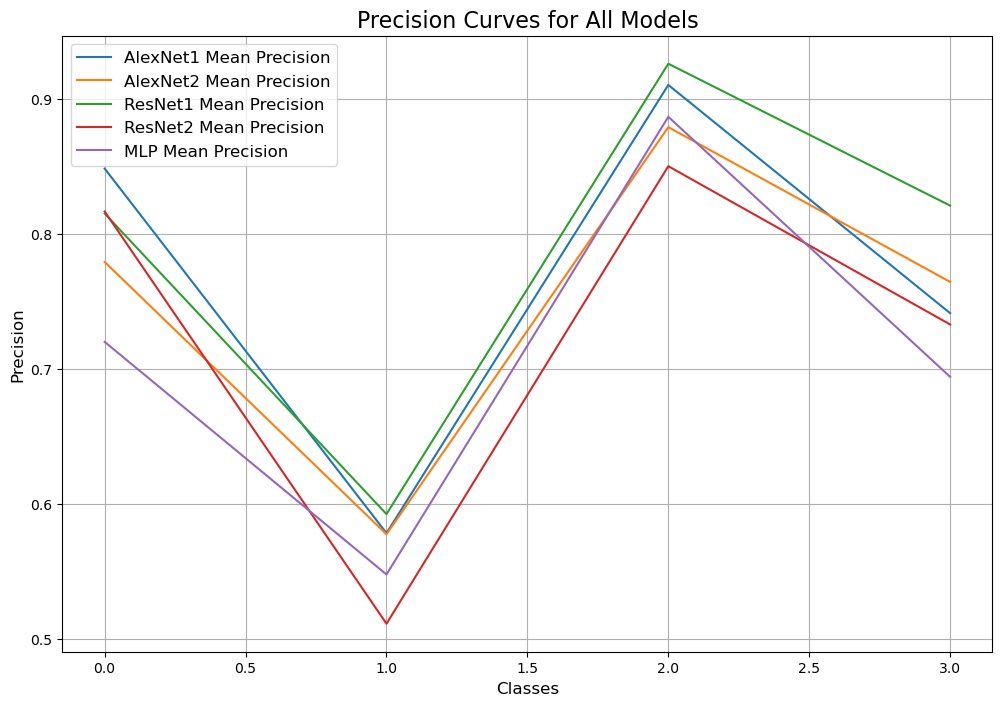

In [10]:
# Precision curves for all models
plt.figure(figsize=(12, 8))

# Iterate over the models in precision_results
for model_name in precision_results:
    precision_data = precision_results[model_name]
    
    # Unpack the precision data
    precision_all = precision_data[0]  # Assuming the first element is precision_all
    precision_mean = precision_data[1]  # Assuming the second element is precision_mean

    # Plot the mean precision for each model
    plt.plot(np.mean(precision_all, axis=0), label=f"{model_name} Mean Precision")

# Customize the plot
plt.title("Precision Curves for All Models", fontsize=16)
plt.xlabel("Classes", fontsize=12)
plt.ylabel("Precision", fontsize=12)
plt.legend(loc="best", fontsize=12)
plt.grid(True)
plt.show()


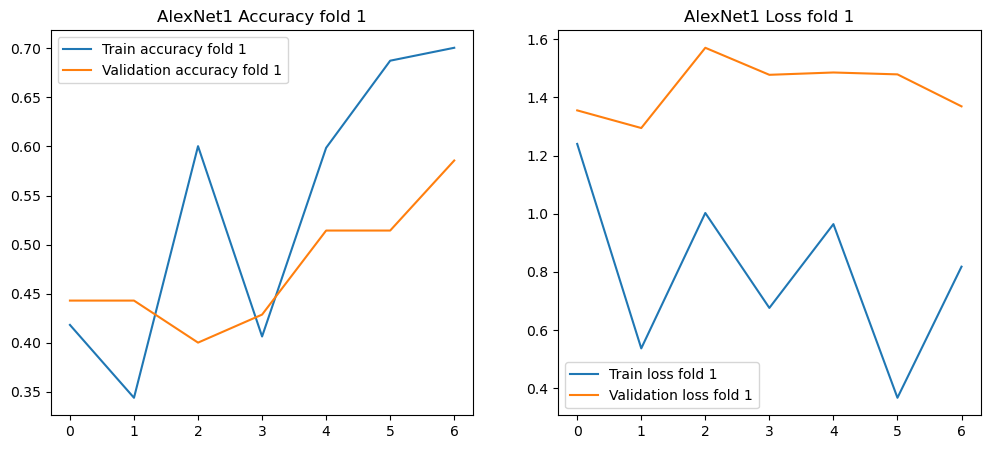

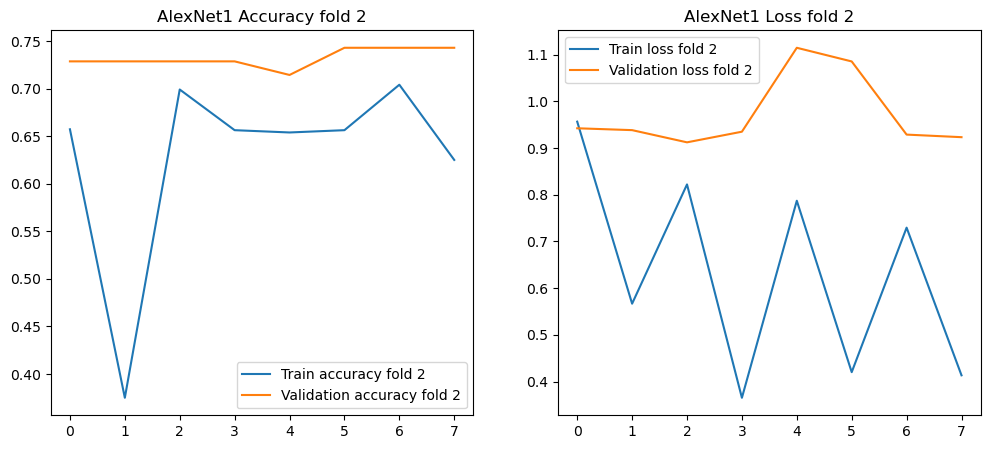

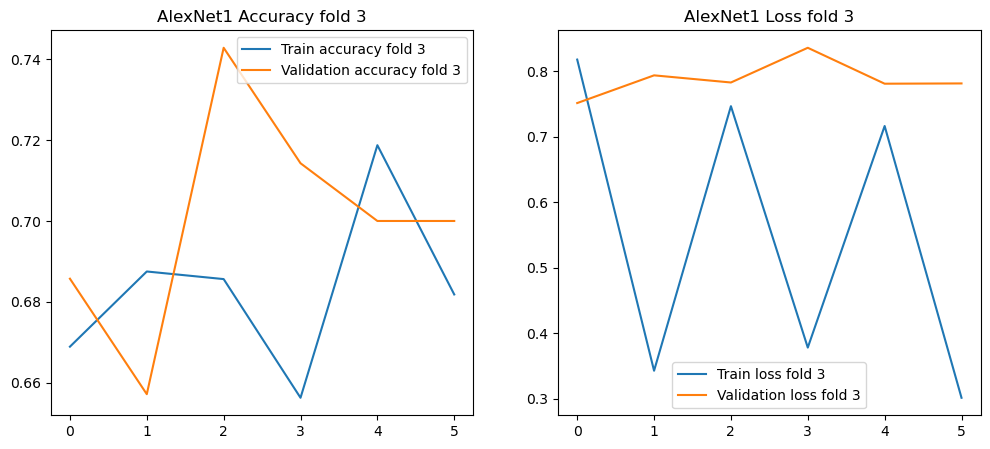

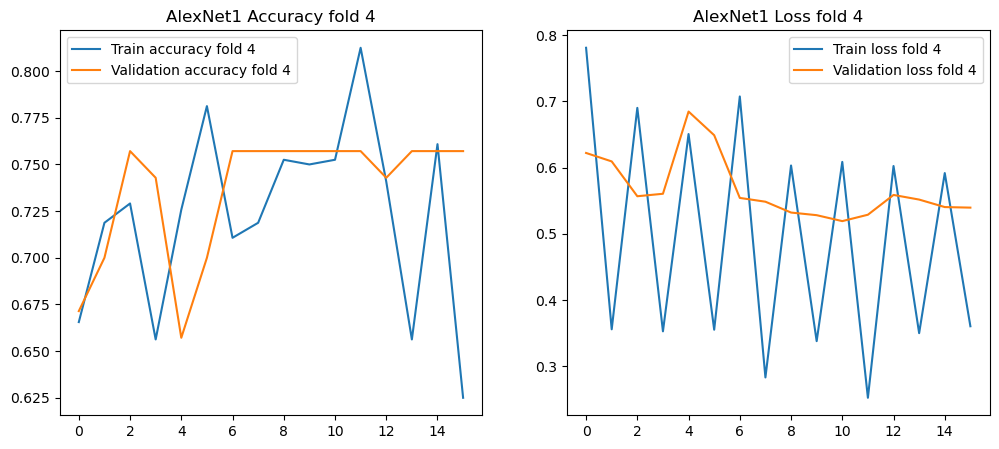

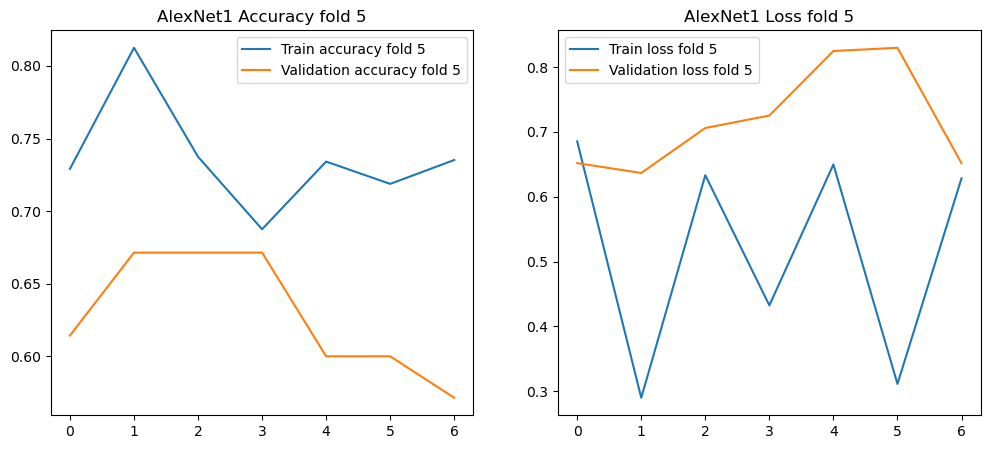

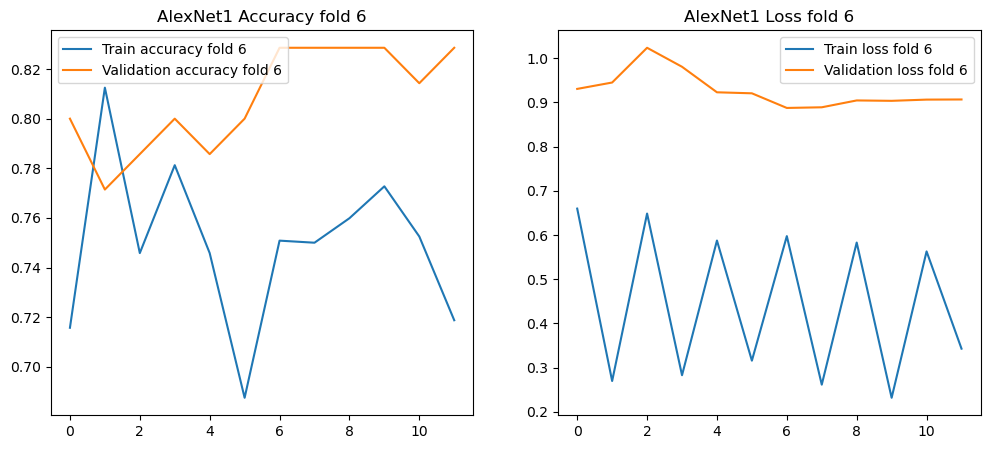

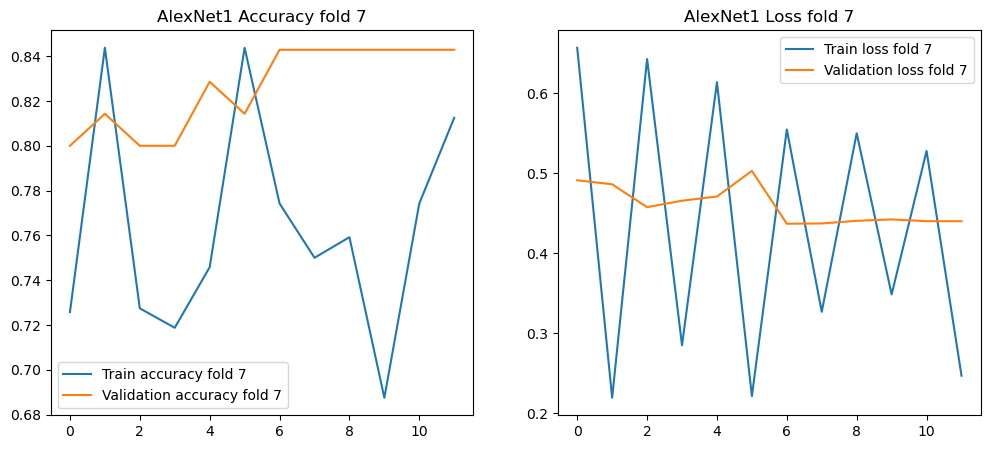

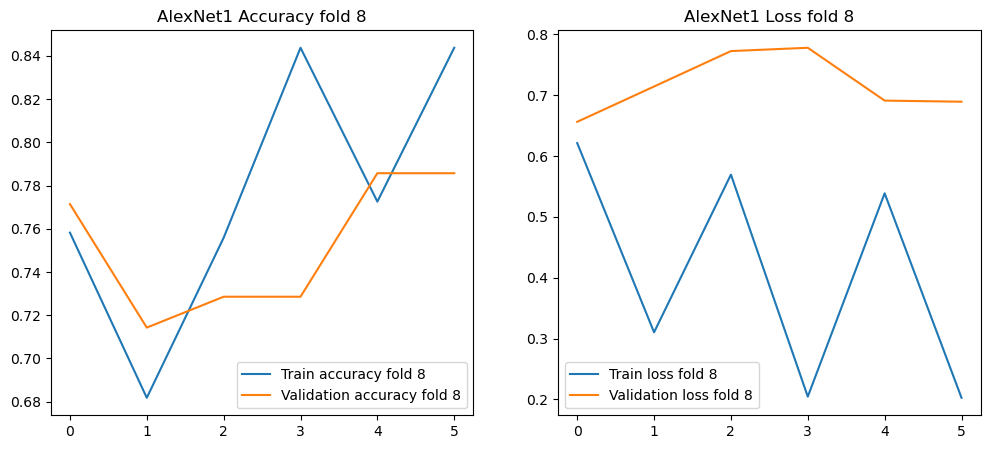

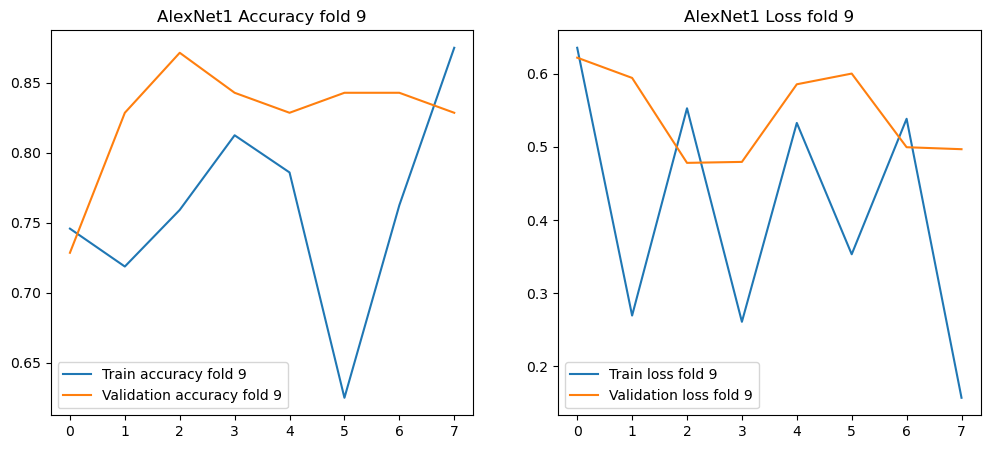

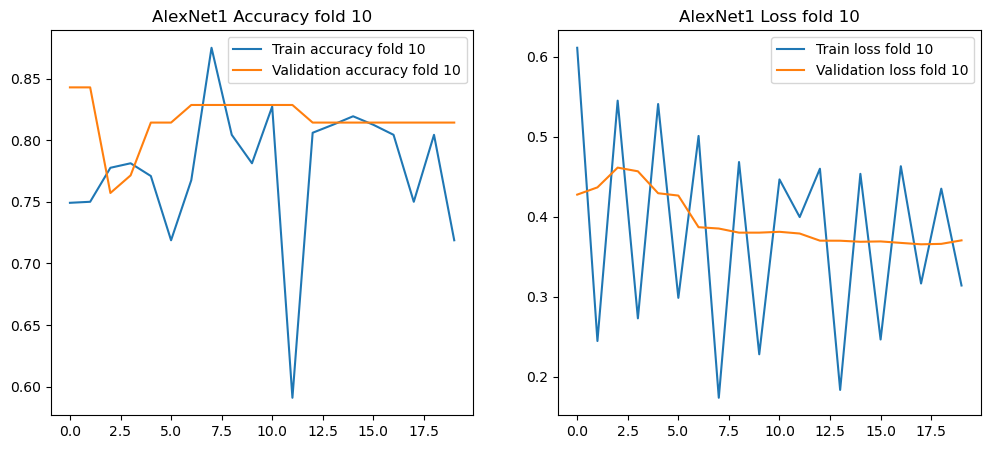

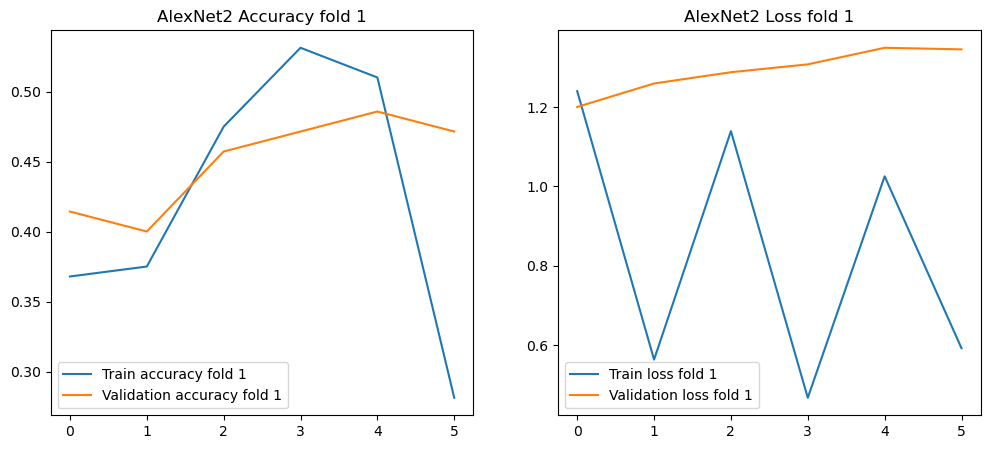

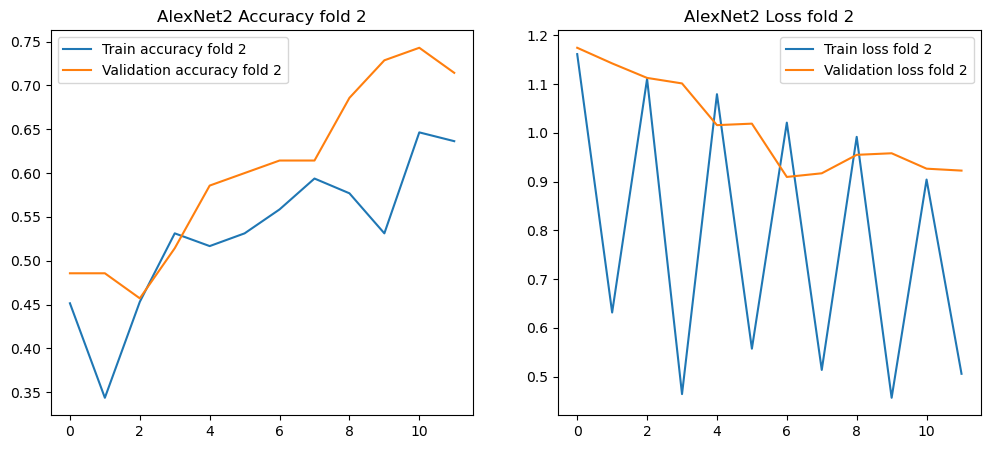

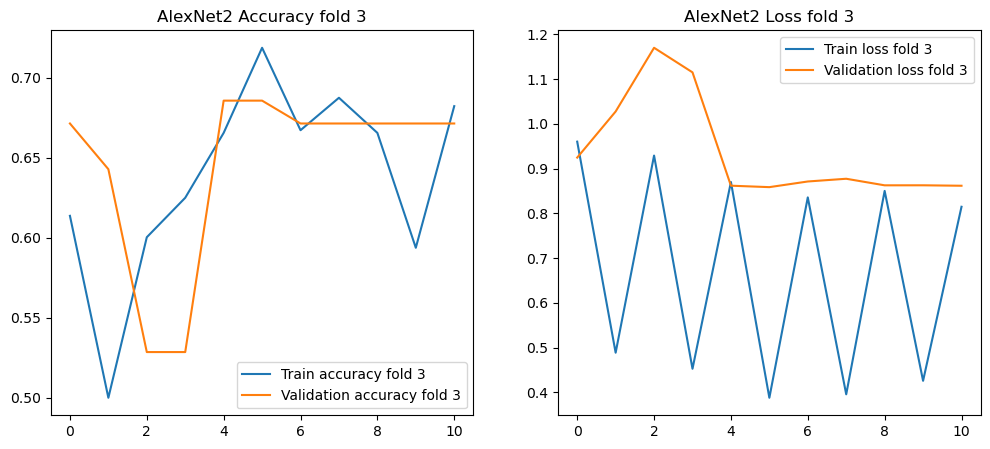

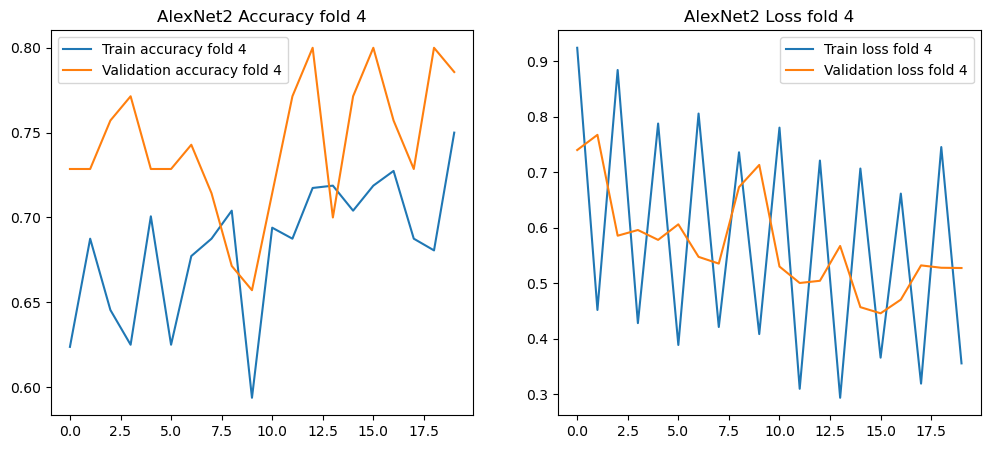

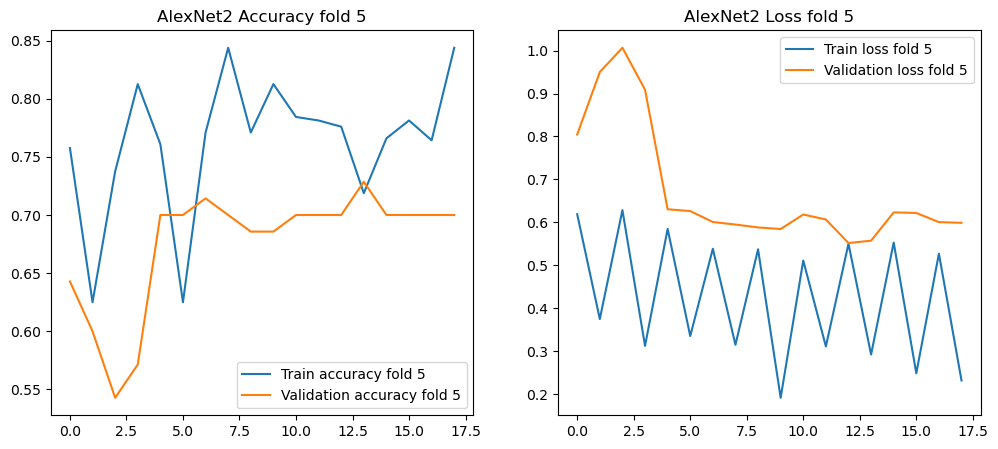

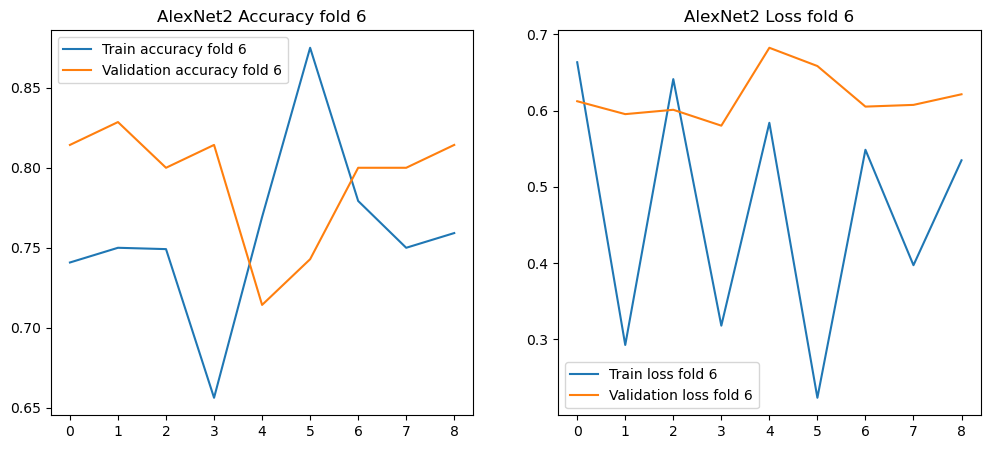

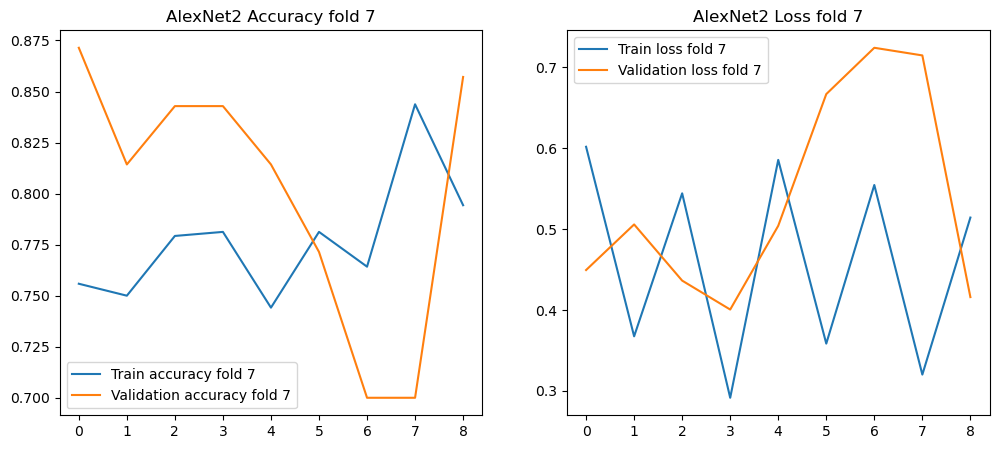

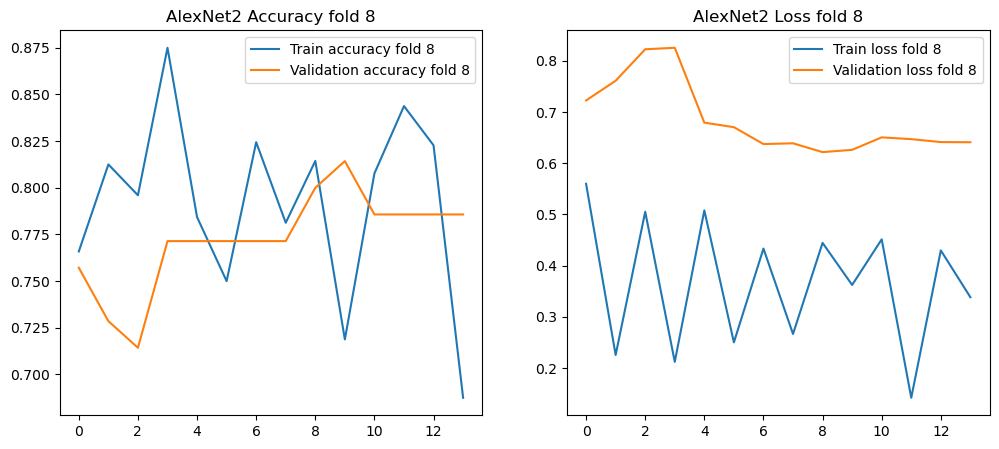

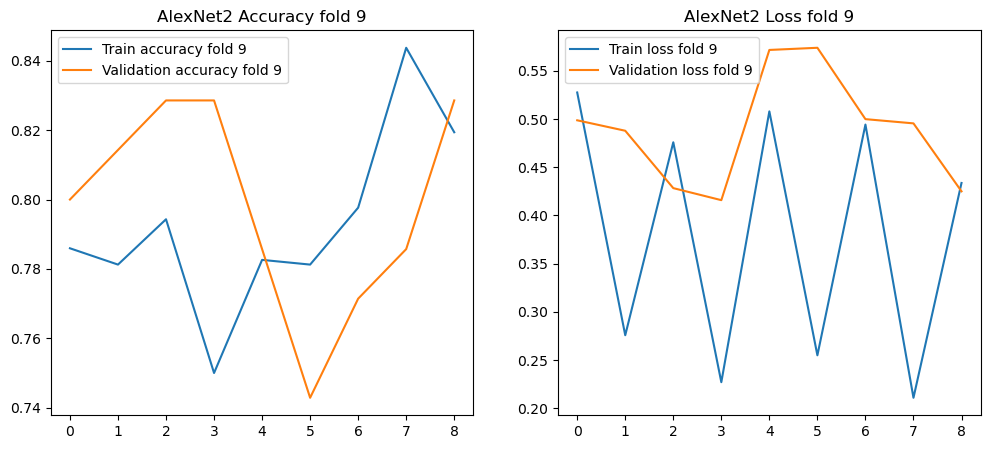

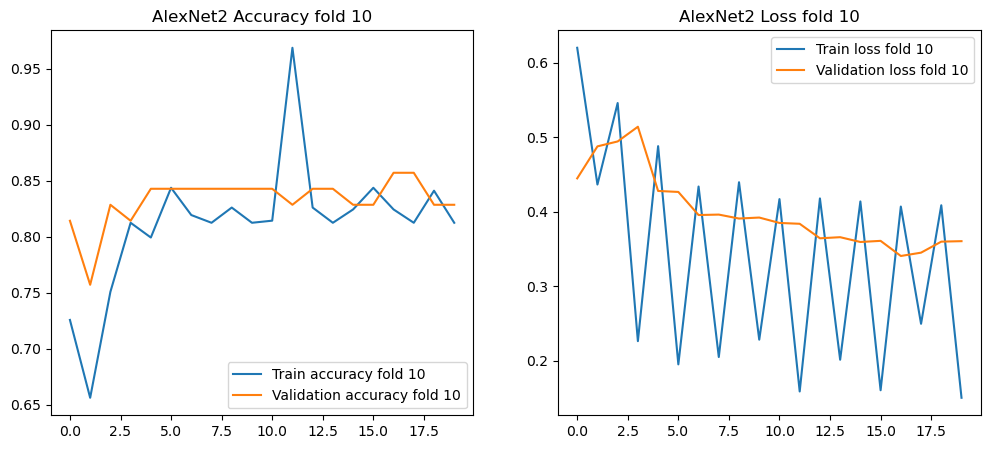

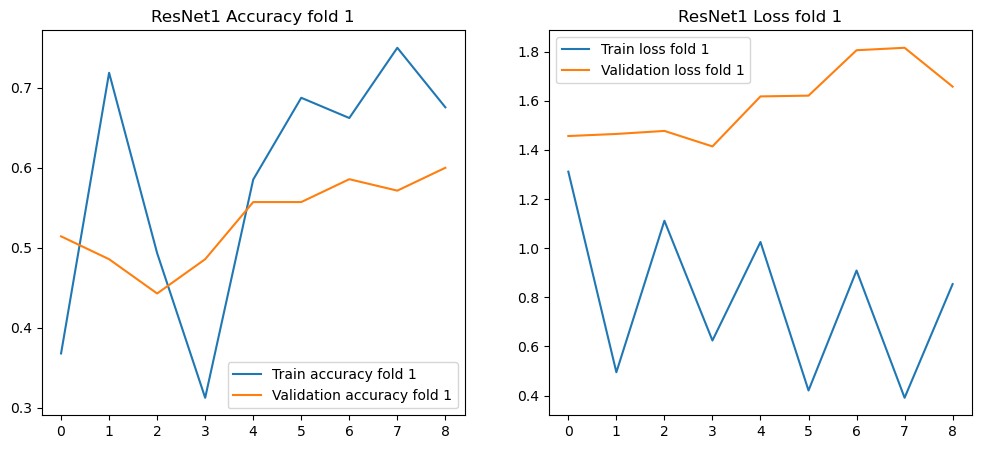

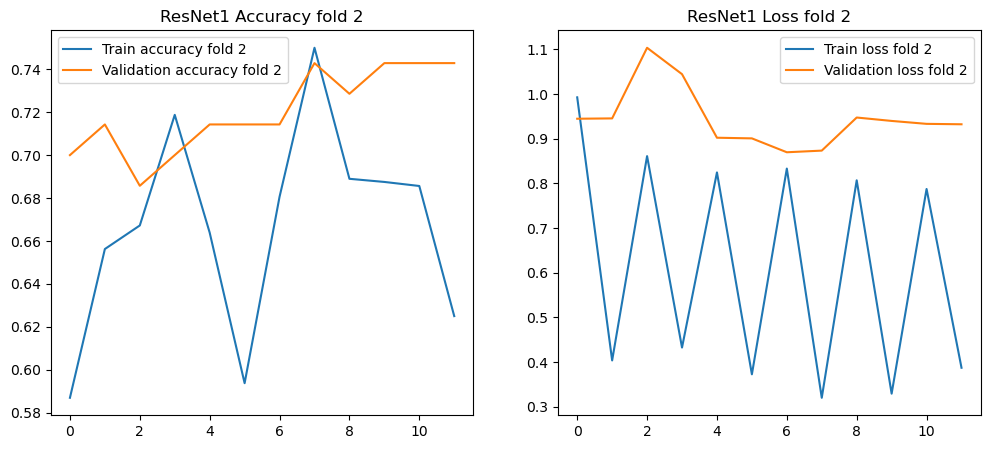

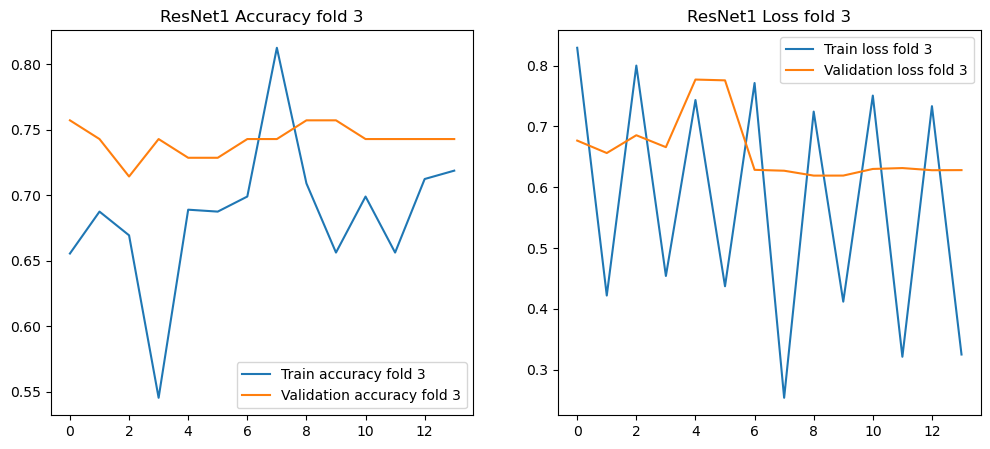

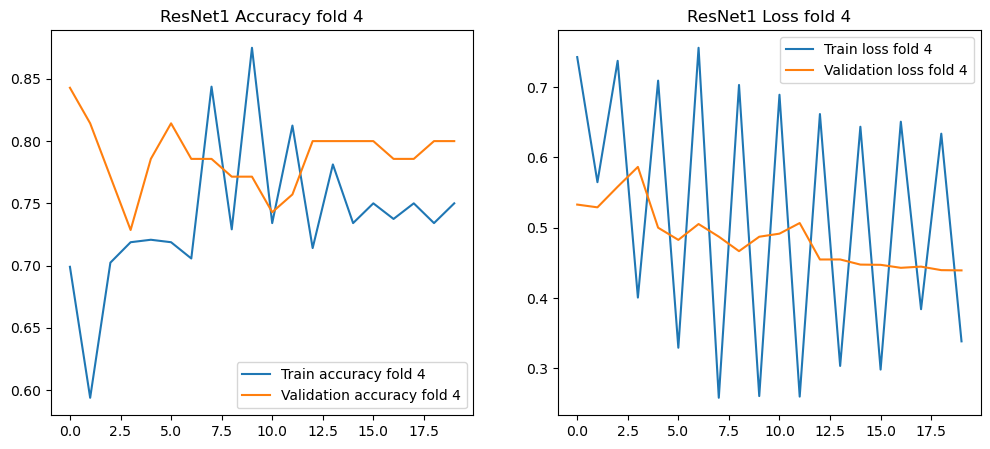

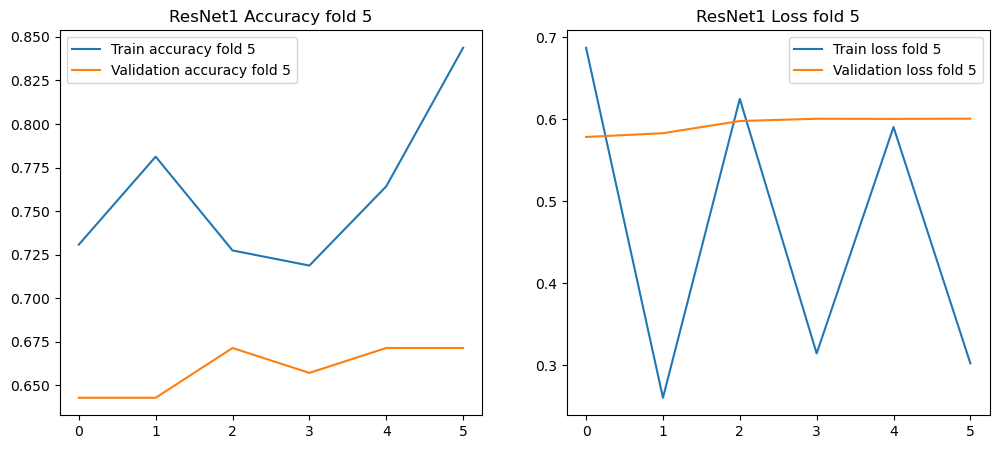

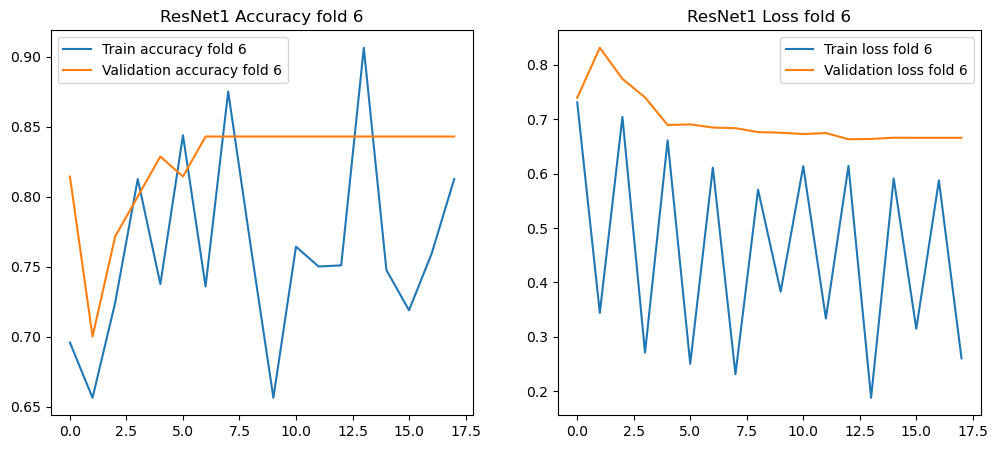

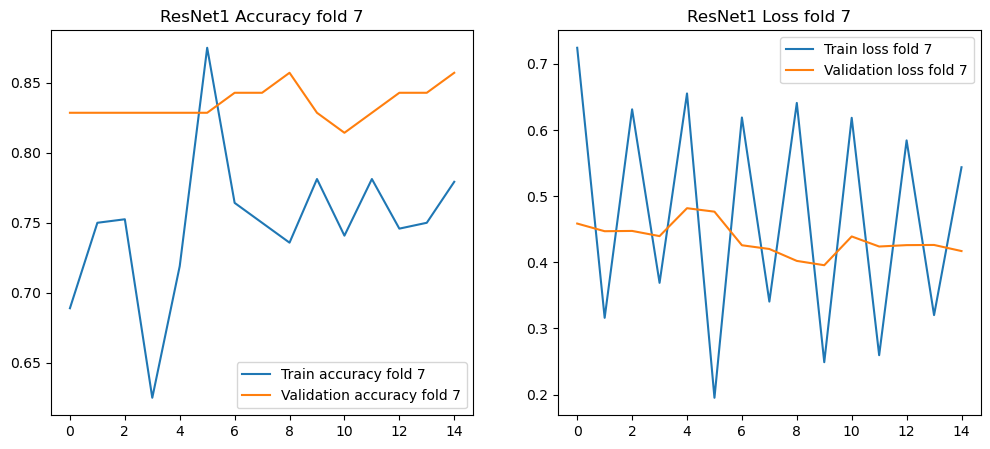

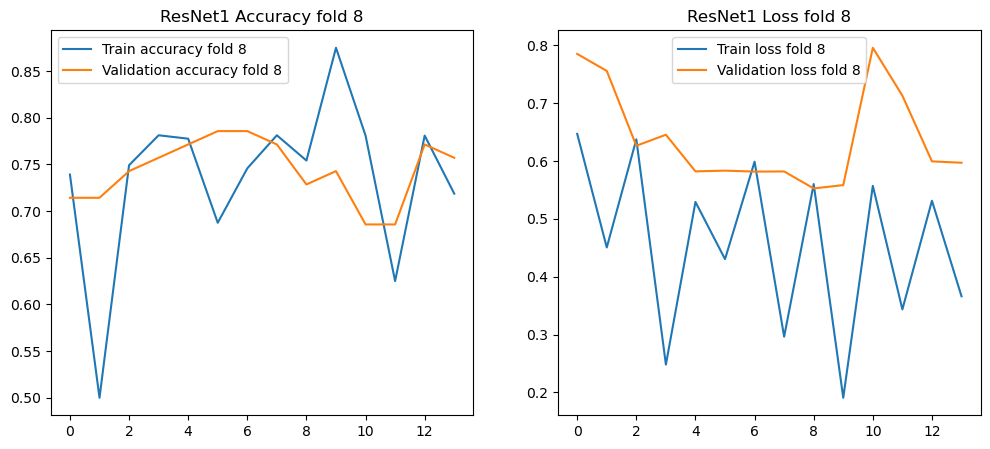

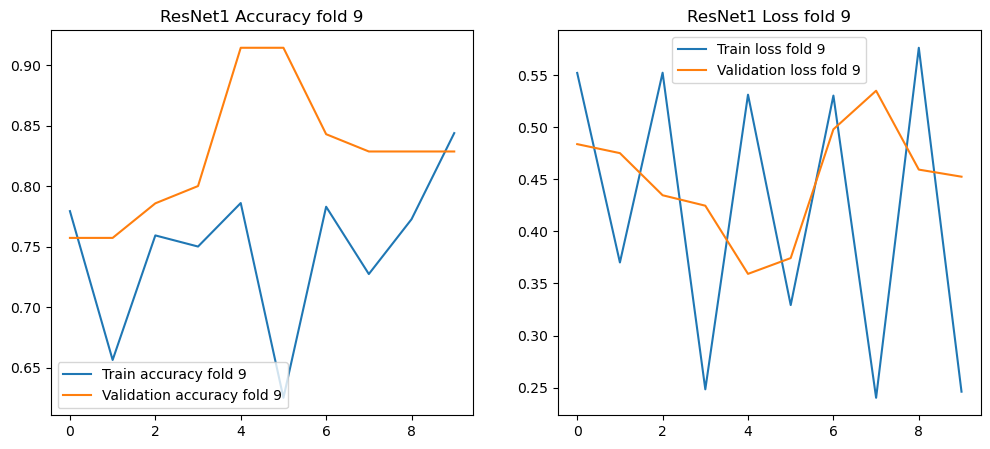

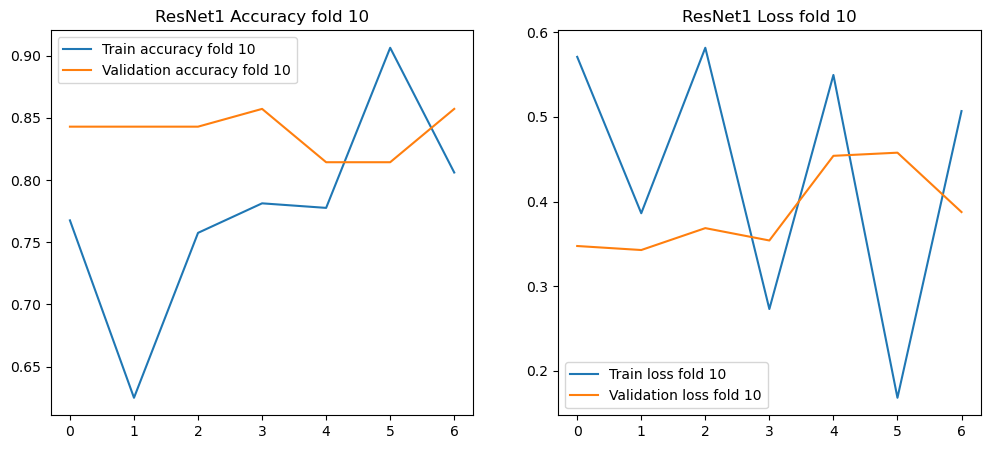

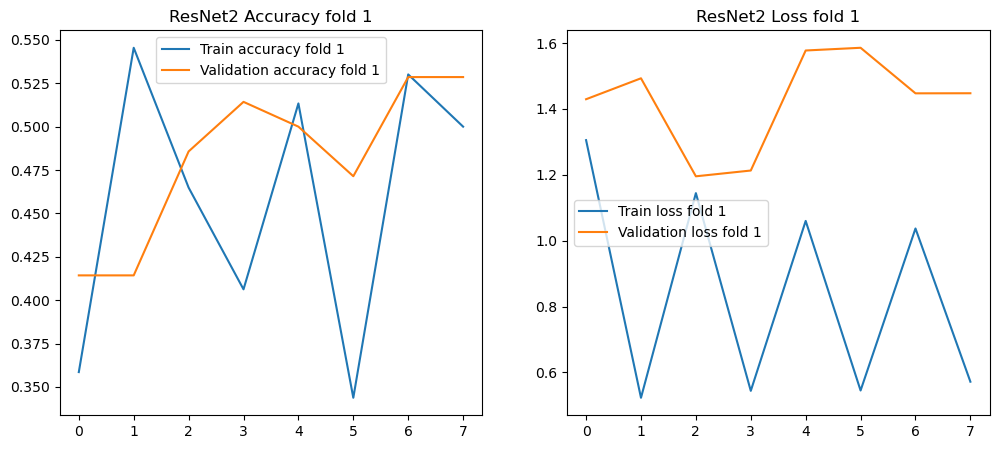

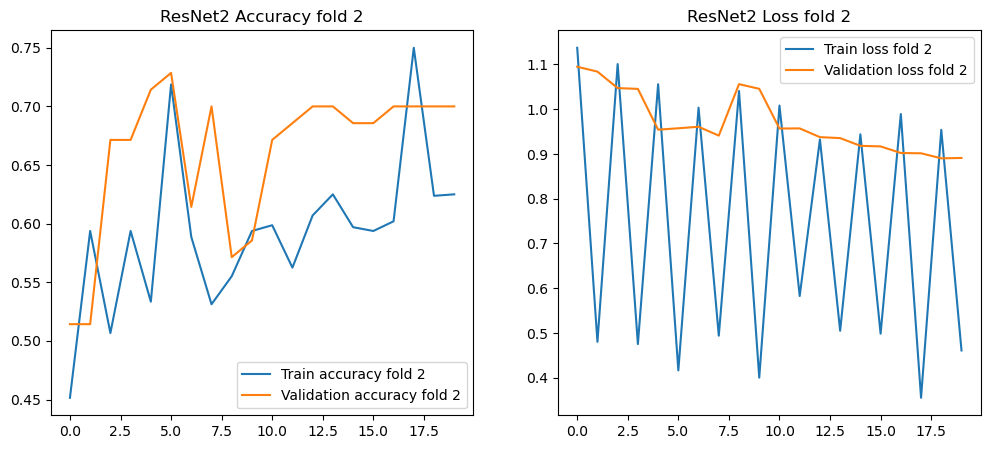

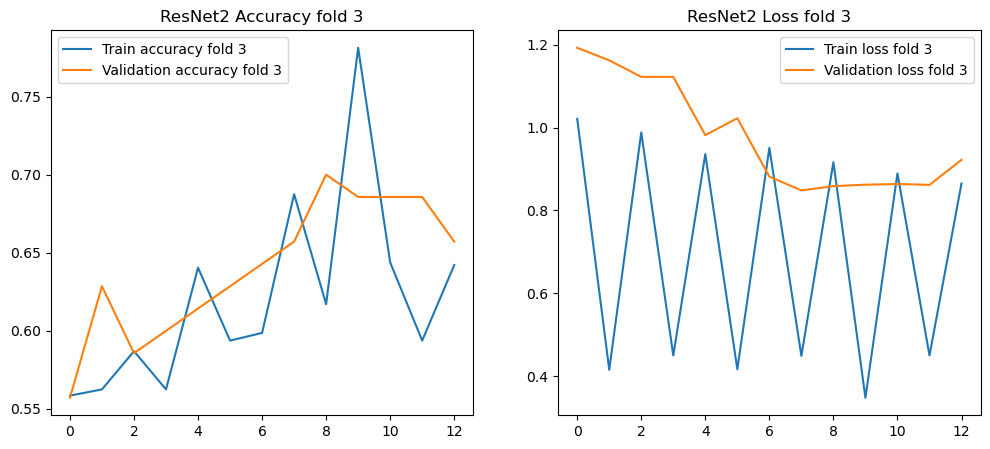

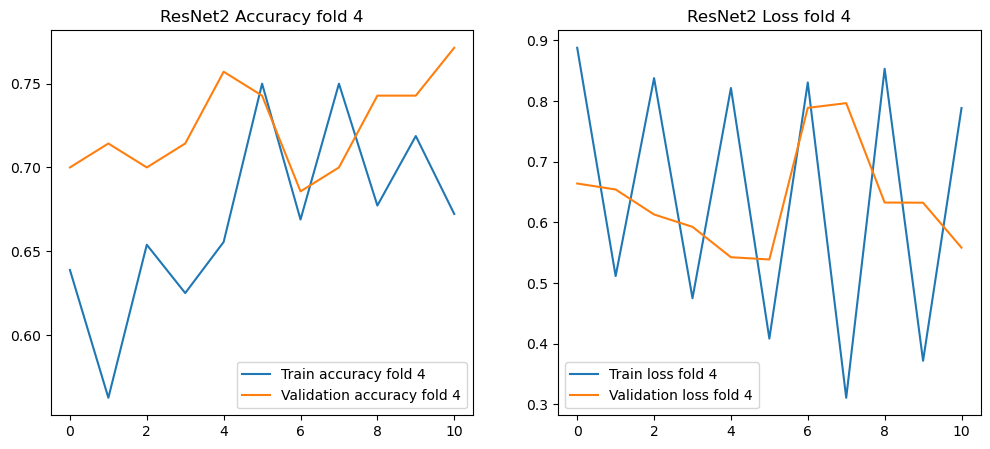

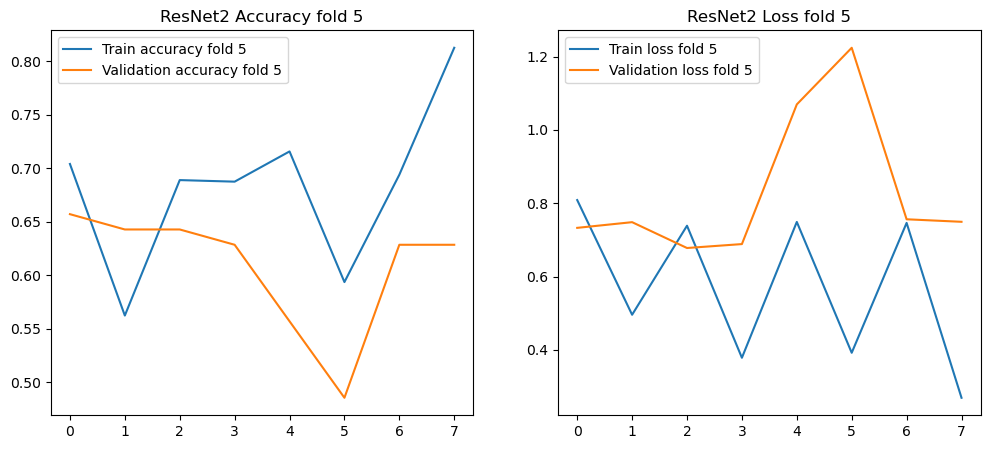

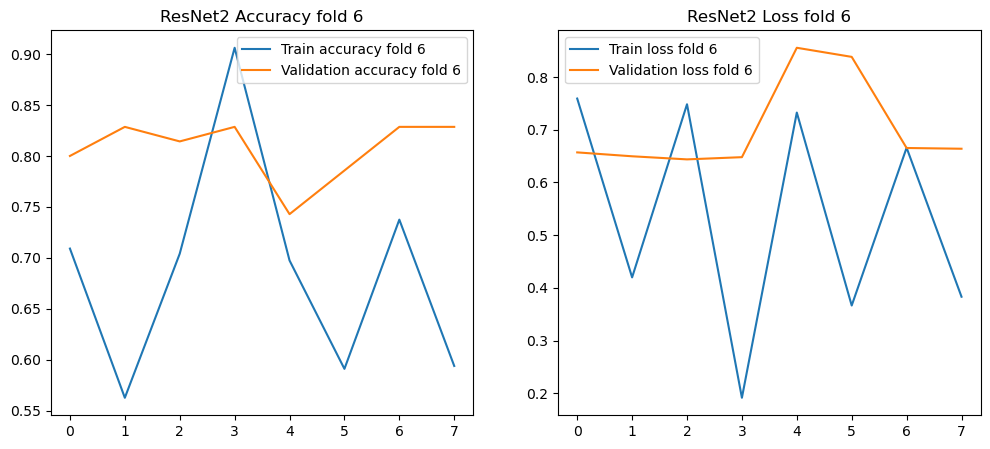

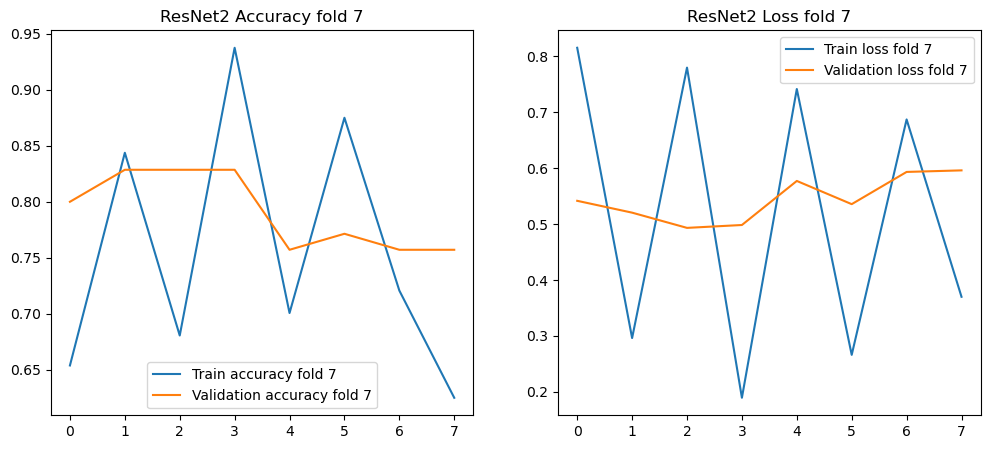

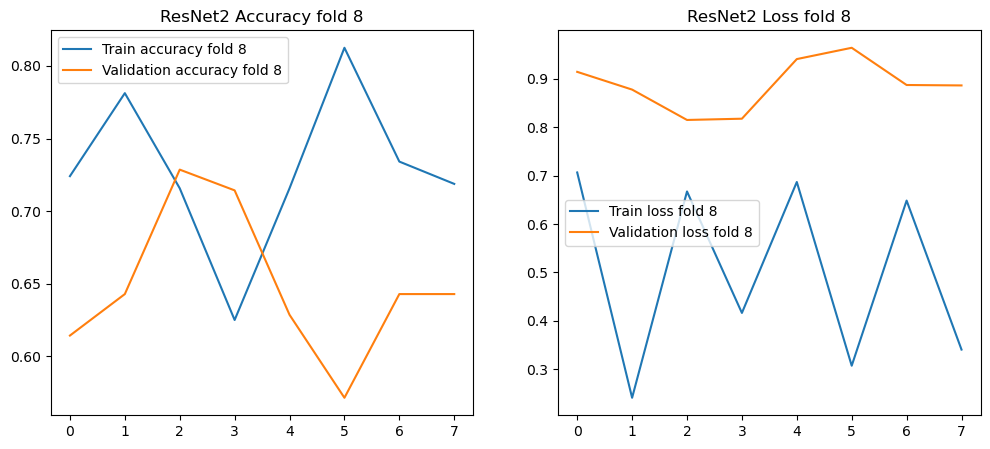

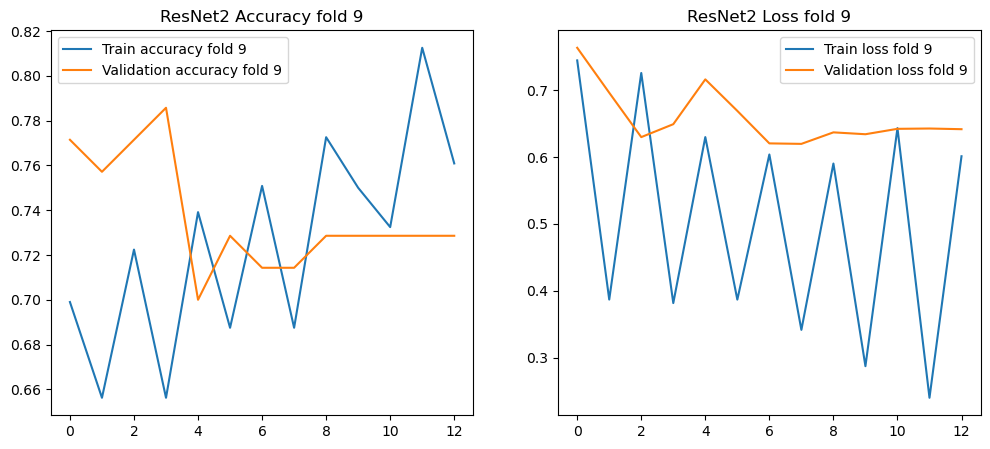

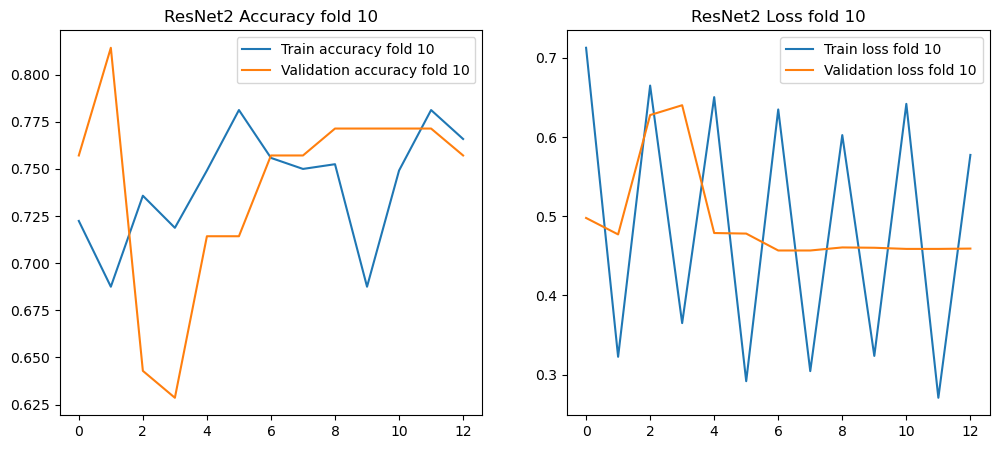

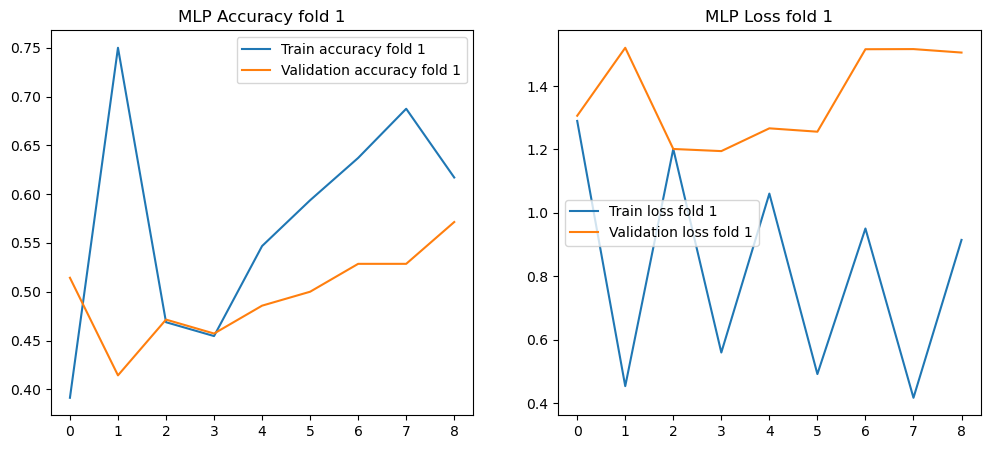

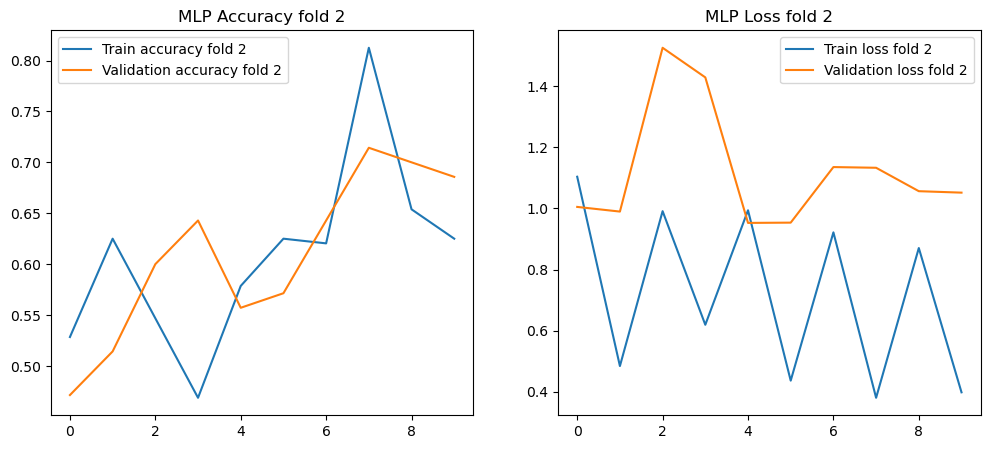

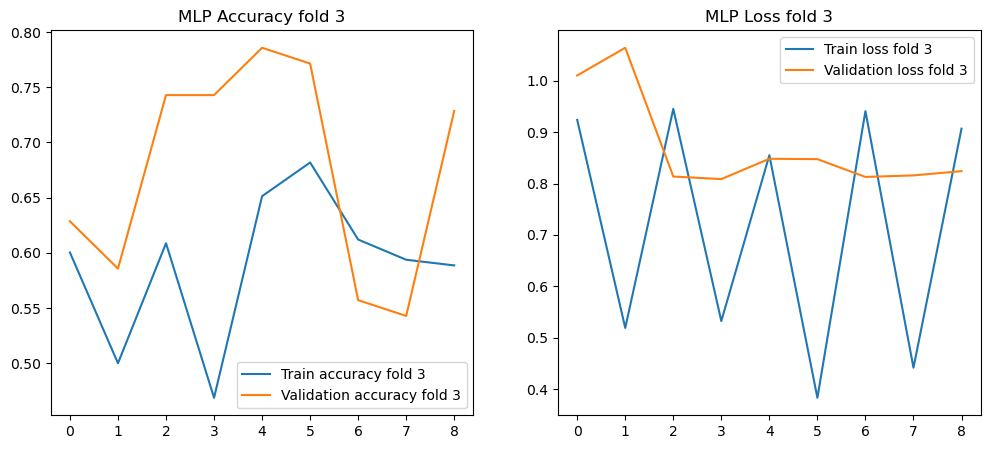

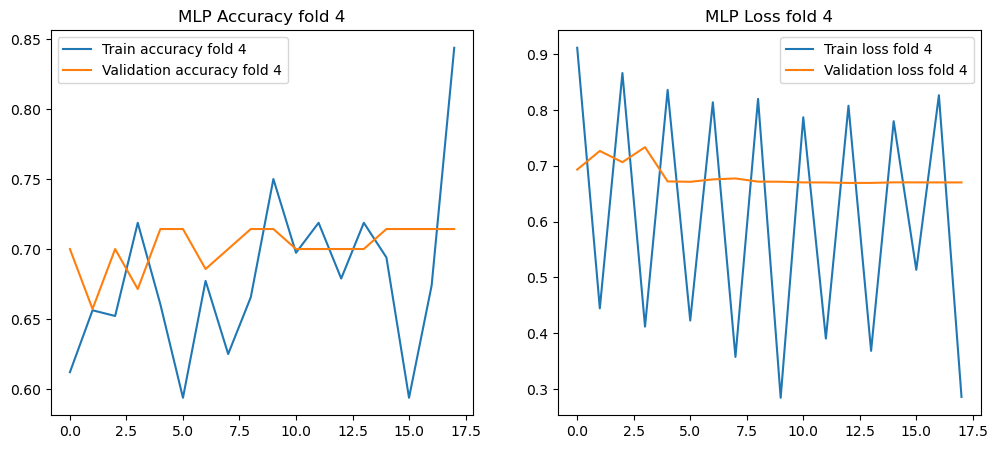

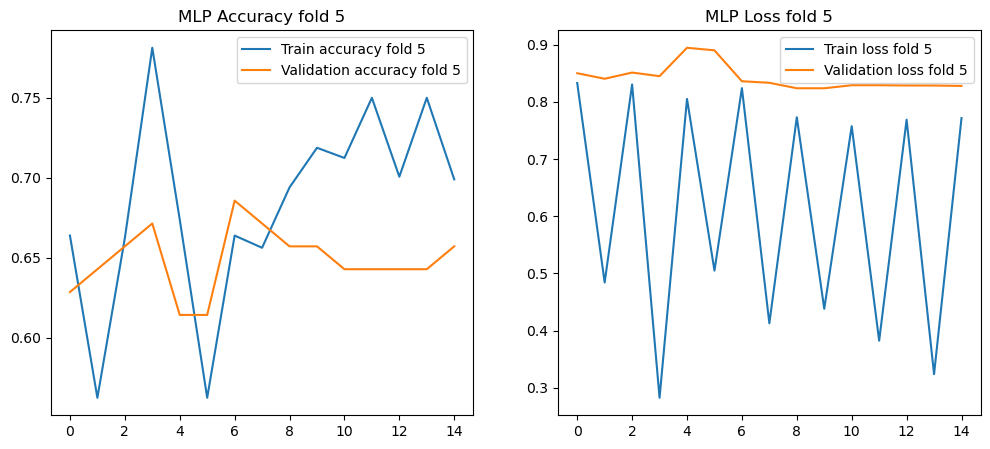

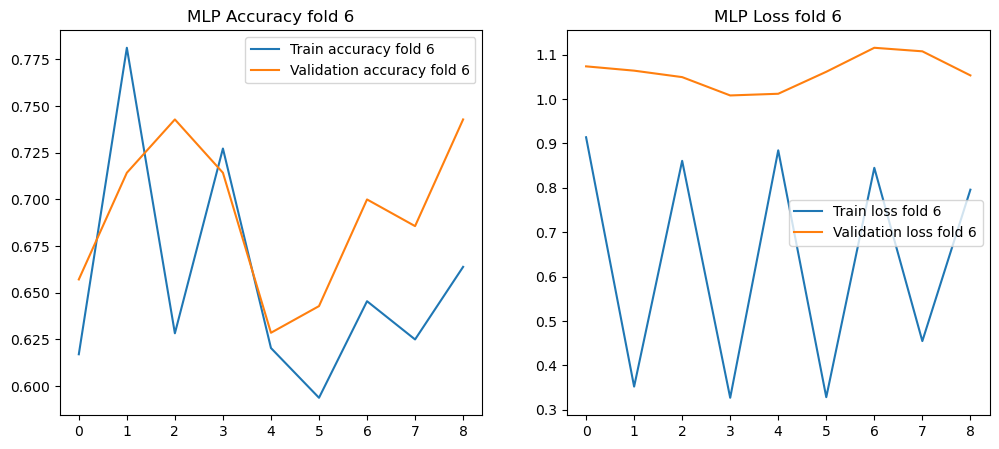

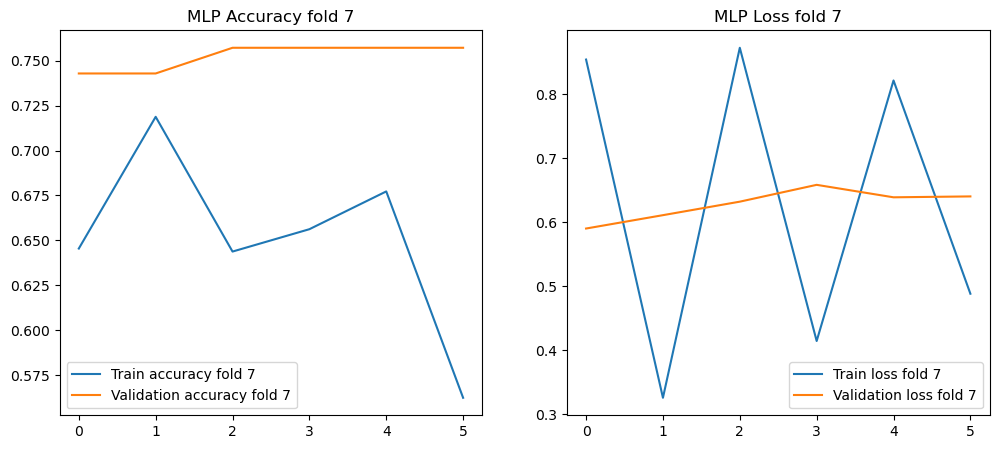

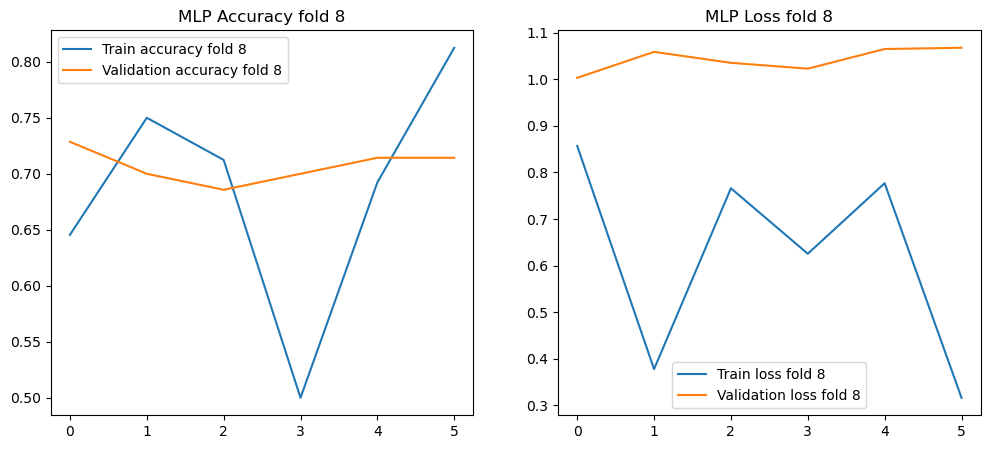

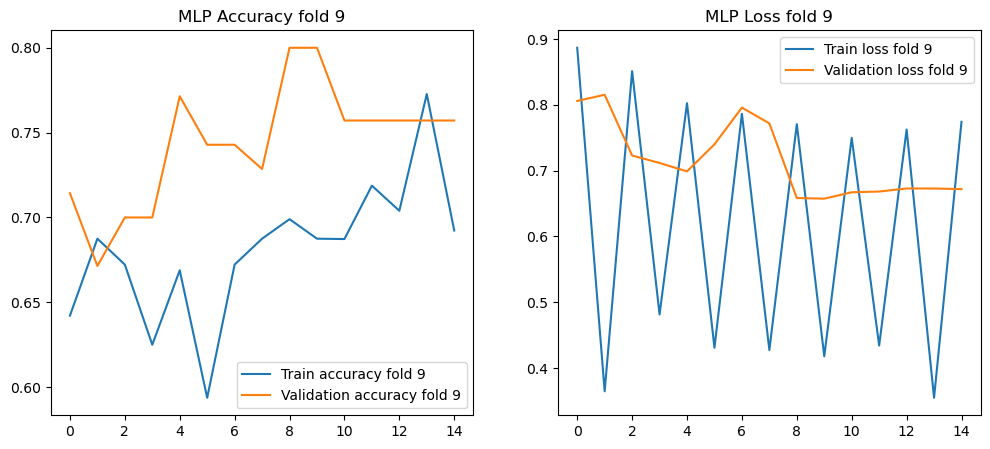

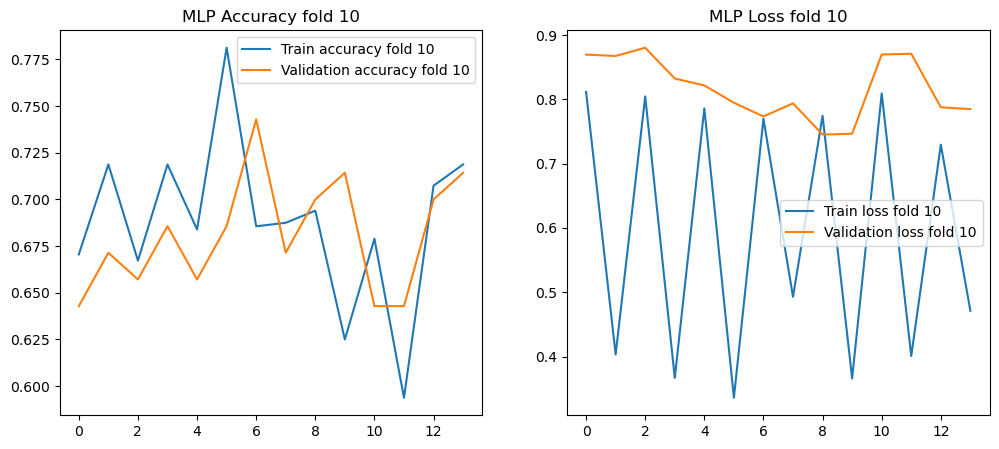

In [11]:
# Accuracy and loss curves for each model
for model_name in precision_results:
    # Assuming the third element in precision_results is the history data
    precision_all, precision_mean, history_all = precision_results[model_name]

    # Plot accuracy and loss for each fold
    for i, history in enumerate(history_all):
        epochs_range = range(len(history.history['loss']))  # Adjust epochs range based on the actual history length

        plt.figure(figsize=(12, 5))

        # Plot accuracy
        plt.subplot(1, 2, 1)
        plt.plot(epochs_range, history.history['accuracy'], label=f"Train accuracy fold {i+1}")
        plt.plot(epochs_range, history.history['val_accuracy'], label=f"Validation accuracy fold {i+1}")
        plt.legend()
        plt.title(f"{model_name} Accuracy fold {i+1}")

        # Plot loss
        plt.subplot(1, 2, 2)
        plt.plot(epochs_range, history.history['loss'], label=f"Train loss fold {i+1}")
        plt.plot(epochs_range, history.history['val_loss'], label=f"Validation loss fold {i+1}")
        plt.legend()
        plt.title(f"{model_name} Loss fold {i+1}")

        plt.show()
